# Credit Card Service Prediction Model

# Load Libraries

In [223]:
# Cargar librerias
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams 
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import scipy.stats as stats 

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_info_rows', 100)

# to make this notebook's output identical at every run
np.random.seed(42)

# Function Definitions

In [2]:
def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', index_col=False, header='infer', float_precision=2 )
    return df

def draw_col_shape(df_feature,cols):
    # draw a bar graph with he number of members of a columns specify in field Cols
    
    # Dictionary for X Axis Labels
    dict_cols = { 'income':'Income', 'member_status':'Member Status','state_grouped': 'State', 'credit_ranges':'Credit Range',
                 'cancel_reason':'Cancel Reason','renew_method':'Renewal Method','sc_vehicle_manufacturer_name':'Vehicle Manufacturer',
                 'sc_vehicle_model_name':'Vehicle Model','race': 'Ethnic Group','home_owner': 'Home Owner','education':'Education Level', 
                 'dwelling_type': 'Dwelling Type', 'gender':'Gender','occupation_code':'Occupation', 'occupation_group':'Occupation Group',
                 'occupant_type': 'Occupant Type','mosaic_household':'Mosaic household','mosaic_global_household':'Global Mosaic',
                 'kcl_b_ind_mosaicsgrouping':'Mosaic Grouping', 'plus_indicator_description':'Membership Type',
                 'tenure':'Tenure Range', 'generation':'Generation', 'total_calls':'Total Breakdown Calls', 
                 'aaa_mortgage':'Used Mortgage Service', 'aaa_credit_card':'Use Credit Card Service','aaa_deposit':'Use Deposit Service',
                 'aaa_home_equity':'Use Home Equity Service', 'aaa_financial_service':'Use Financial Service', 
                 'aaa_auto_insurance':'Use Insurance Service', 'vehicle':'Vehicle','total_member_cost':'Total Member Avg. Costs',

                }


    # number of members per state

    for col in cols:
        counts = df_feature[col].value_counts()
        sns.set(style="whitegrid")
        plt.axhline(0, color="k", clip_on=False)
        plt.ylabel("# of Classes",fontsize=14, fontweight='bold')
        plt.xlabel("Classes", fontsize=14, fontweight='bold')
        plt.title('Total  Number of Classes',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
        sns.barplot(counts.index, counts.values)
        plt.xticks(
            rotation=45, 
            horizontalalignment='right',
            fontweight='light',
            fontsize='large')
        i = 0
        for v in list(counts.values):
            plt.text(i-.25, v, str(v), color='blue', fontweight='bold')
            i +=1
        plt.show()
        counts = pd.DataFrame(df_feature[col].value_counts().nlargest(15), index=None)
        counts.reset_index(inplace=True)
        counts.rename(columns={"index": dict_cols[col], col: "# of Classes"}, inplace=True)
        fig = ff.create_table(counts, height_constant=30, index=False)
        py.iplot(fig)
        return

# Load data from consolidate file by household key and transacton file 

In [113]:
# Load data from the View create using Capstone AAA - EDA .ipynb
df_household = read_data('household_view.csv')
df_transaction = read_data('capstone_aaa_featured.csv')
df_original_house_hold = df_household.copy()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df_household.groupby('aaa_credit_card').mean()

,household_key,zip,aaa_no_tenure,aaa_member_tenure_years,aaa_mean_age,length_of_residence,aaa_mortgage,aaa_deposit,aaa_home_equity,aaa_financial_service,aaa_auto_insurance,aaa_motorcycle_indicator,aaa_mean_child,aaa_mean_total_cost,aaa_no_race,aaa_no_home_owner,aaa_no_education,aaa_no_income,aaa_no_dwelling_type,aaa_no_credit_ranges,aaa_no_gender,aaa_no_language,aaa_no_reason_joined,aaa_cancel_reason,aaa_no_mosaic_household,aaa_no_mosaic_global_household,aaa_no_kcl_b_ind_mosaicsgrouping,aaa_no_occupation_code,aaa_no_occupation_group,aaa_no_occupant_type,aaa_no_plus_indicator_description,aaa_no_generation,total_calls_year_1,total_calls_year_2,total_calls_year_3,total_member_cost_1,total_member_cost_2,total_member_cost_3,total_calls,total_member_cost,total_cost
aaa_credit_card,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,14979687.6875,3112.6776,1.0249,46.5727,75.2968,5.7709,0.0019,0.0049,0.0011,0.0641,0.2628,0.5535,1.7127,22.0491,2.7387,0.1187,1.9690,5.1681,0.4235,2.5173,1.5945,0.1688,2.6944,3.9200,10.8925,3.1575,5.0136,7.4830,5.6387,1.3264,0.9654,0.9954,1.5867,2.9048,2.9434,86.4321,158.6718,152.4586,7.4348,397.5624,122.1690
1,14055339.8720,2901.4740,0.6747,48.0208,72.2405,7.8025,0.0035,0.0087,0.0017,0.1194,0.3737,0.5485,1.7378,26.5277,3.0741,0.0616,2.0000,4.5911,0.3142,2.5389,1.6000,0.2651,2.9500,4.3143,9.6253,2.8847,4.6031,6.1723,6.3974,1.1892,1.0196,1.2213,2.1626,3.5813,3.9481,112.6133,190.6702,198.8798,9.6920,502.1633,155.0735


In [17]:
df_transaction.groupby(by=['household_key','fsv_credit_card_flag']).mean()

individual_key  member_flag      zip5          zip9  fsv_cmsi_flag  fsv_deposit_program_flag  fsv_home_equity_flag  fsv_id_theft_flag  fsv_mortgage_flag  ins_client_flag  trv_globalware_flag  length_of_residence  do_not_direct_mail_solicit  email_available  ers_ent_count_year_1  ers_ent_count_year_2  ers_ent_count_year_3  ers_member_cost_year_1  ers_member_cost_year_2  ers_member_cost_year_3  right_individual_key   member_key  member_number_associate_id  member_tenure_years  membership_id  months_from_join_to_cancel       zip  new_mover_flag  basic_cost  calculated_tow_miles  call_canceled  call_killed  cash_call  fleet_indicator  is_duplicate  is_nsr  member_match_flag  member_number_and_associate_id  motorcycle_indicator  plus_cost  premier_cost       rec_id  total_cost  tow_destination_latitude  tow_destination_longitude  was_duplicated  was_towed_to_aar_referral  no_child  no_race  no_home_owner  ...  no_income  no_dwelling_type  \
household_key fsv_credit_card_flag                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ...                                
875           0                      65070131.7647       1.0000 2920.7647 29209378.1765         0.0000                    0.0000                0.0000             0.0000             0.0000           0.0000               0.0000               0.0000                      0.0000           0.2941                0.6471                0.3529                0.5294                 38.0794                 20.7706                 68.7506         65070131.7647 3193116.5294               18051553.7059              29.7647    180515.4118                     37.1176 2920.7647          0.0000     38.9529                6.6000         0.0000       0.0000     0.0000           0.9231        0.0000  0.0588             0.7647                   17367550.0000                0.2308    17.6471        0.0000 5735607.8235     56.6000                   22.3636                   -38.7273          0.0588                     0.0000       nan      nan            nan  ...        nan            0.4706   
              1                       4653610.0000       1.0000 2921.0000 29211601.0000         0.0000                    0.0000                0.0000             0.0000             0.0000           0.0000               0.0000               0.0000                      0.0000           1.0000                0.0000                0.0000                1.0000                  0.0000                  0.0000                 76.5700          4653610.0000 3865984.0000               22711421.0000              15.0000    227114.0000                      0.0000 2921.0000          1.0000     29.0000                0.0000         0.0000       0.0000     0.0000           0.0000        0.0000  0.0000             1.0000                   22711421.0000                0.0000    72.0000        0.0000  668468.0000    101.0000                    0.0000                     0.0000          0.0000                     0.0000       nan      nan            nan  ...        nan            0.0000   
969           0                         19918.5000       1.0000 2919.0000 29191023.0000     

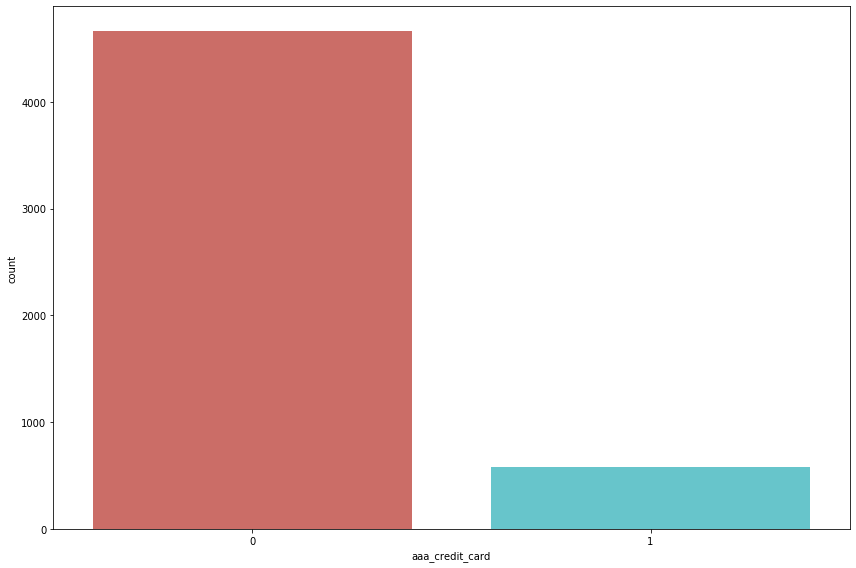

<Figure size 864x576 with 0 Axes>

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x='aaa_credit_card',data=df_household, palette='hls')
plt.show()
plt.savefig('cc_count_plot')

In [20]:
# Income
df_household.income.value_counts()

UNKNOWN          2018
100-149,999       653
90-99,999         611
70-79,999         292
50-59,999         273
10-19,999         227
40-49,999         224
30-39,999         156
60-69,999         151
20-29,999         143
175 - 199,999     138
150 - 174,999     102
200 - 249,999      95
250K+              88
UNDER 10K          67
80-89,999           2
Name: income, dtype: int64

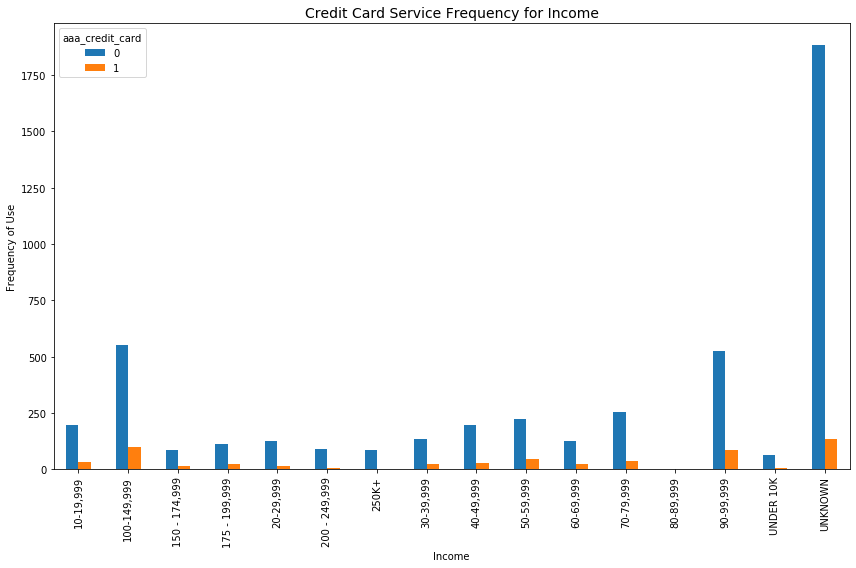

In [21]:
# graph income
pd.crosstab(df_household.income,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Income')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_cc')

## Outcomes
The frequency of credit card use depend heavvily on income. 
Will consolidate income in three categories: 
    a) under 10k - 39999: Under 39.999
    b) 40 - 99,999 : 40 - 99,999
    c) 100k and above : 100+
    

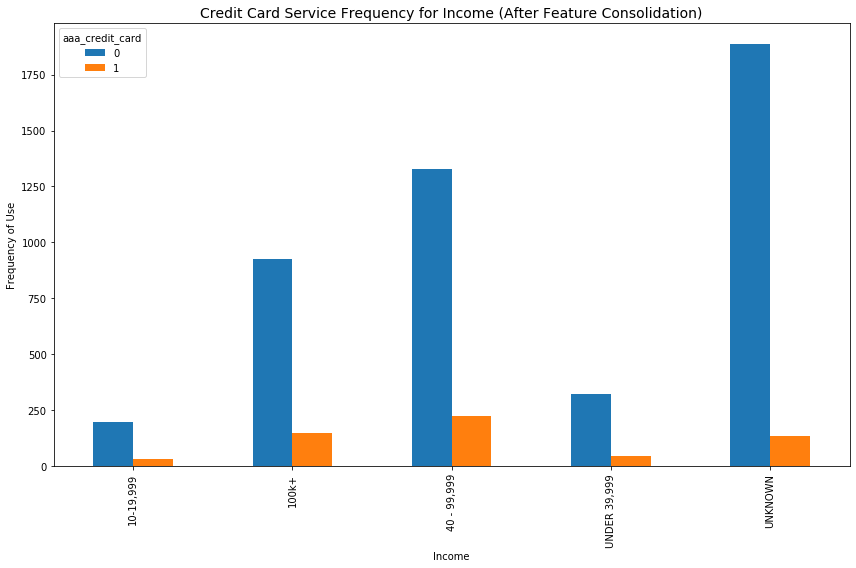

In [22]:
group1 = ['UNDER 10K', '20-29,999', '30-39,999']
group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
for i in group1:
    df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
for i in group2:
    df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
for i in group3:
    df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])

pd.crosstab(df_household.income,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Income (After Feature Consolidation)')
plt.xlabel('Income')
plt.ylabel('Frequency of Use')
plt.savefig('income_use_cc_feat')

In [23]:
# Tenures
df_household.tenure.value_counts()

+40 YEARS                3753
BETWEEN 31 & 40 YEARS     380
BETWEEN 21 & 30 YEARS     305
BETWEEN 6 & 10 YEARS      233
BETWEEN 11 & 15 YEARS     227
BETWEEN 16 & 20 YEARS     166
BETWEEN 1 & 5 YEARS       164
< 1 YEAR                   12
Name: tenure, dtype: int64

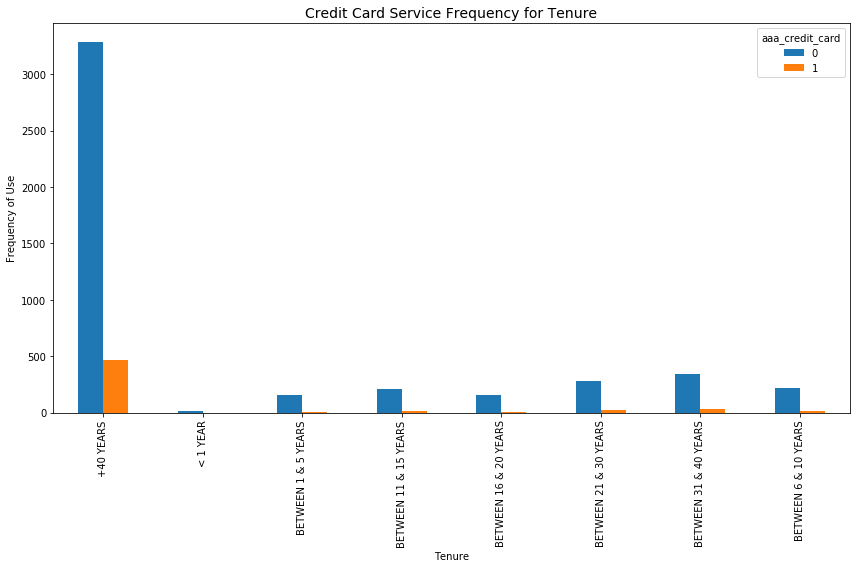

In [24]:
# graph tenure
pd.crosstab(df_household.tenure,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_cc')

# Outcomes
The frequency of credit card use depend heavily on tenures. Will consolidate tenure in three categories: 
a) above 40 years  
b) between 21 - 40 
c) Less 21 


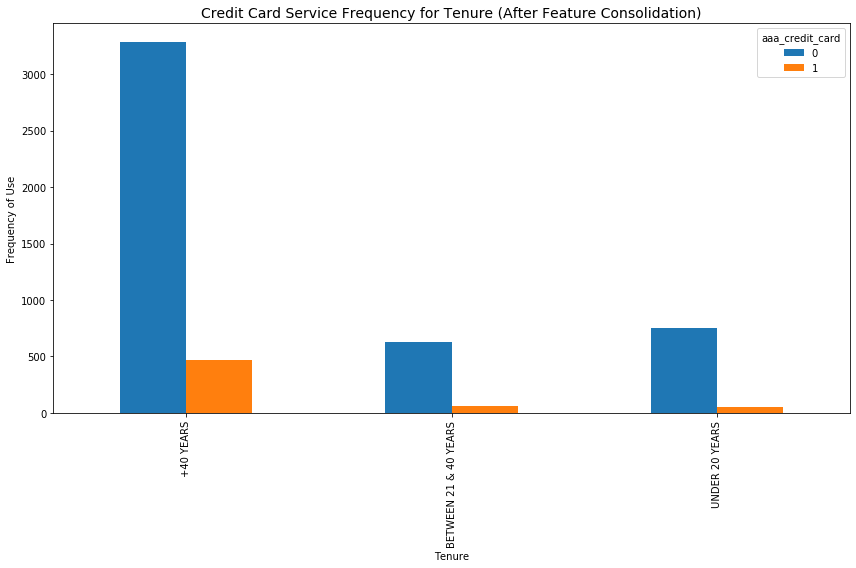

In [25]:
group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
group3 = ['+40 YEARS']
for i in group1:
    df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
for i in group2:
    df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
for i in group3:
    df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])

pd.crosstab(df_household.tenure,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Tenure (After Feature Consolidation)')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('tenure_use_cc_feat')

In [26]:
# Credit Ranges
df_household.credit_ranges.value_counts()

UNKNOWN       2114
750-799       1133
700-749        686
650-699        503
800+           476
600-649        230
550-599         54
500-549         40
499 & LESS       4
Name: credit_ranges, dtype: int64

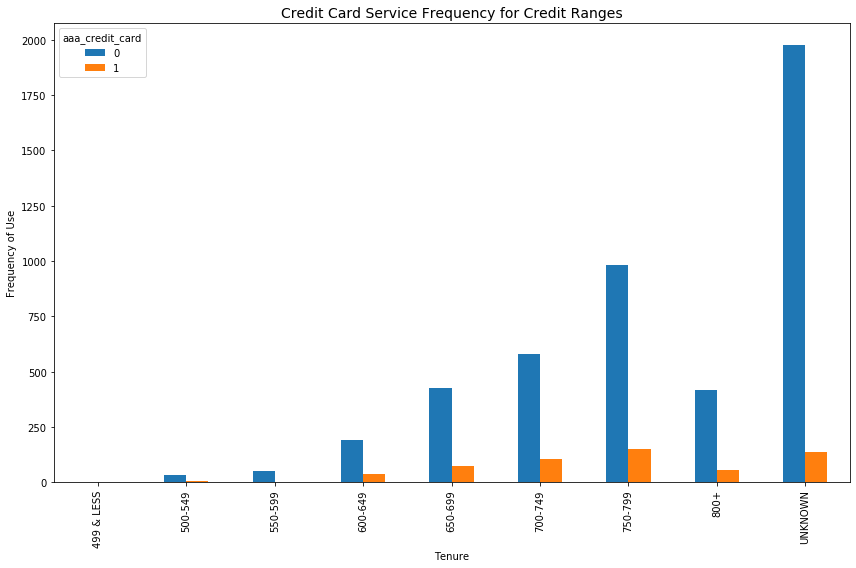

In [27]:
# graph credit ranges
pd.crosstab(df_household.credit_ranges,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Credit Ranges')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_cc')

# Outcomes
The frequency of credit card use depend heavily on credit_ranges. Will consolidate tenure in three categories: a) above 800 years b) between 700 - 799 c) Below 700

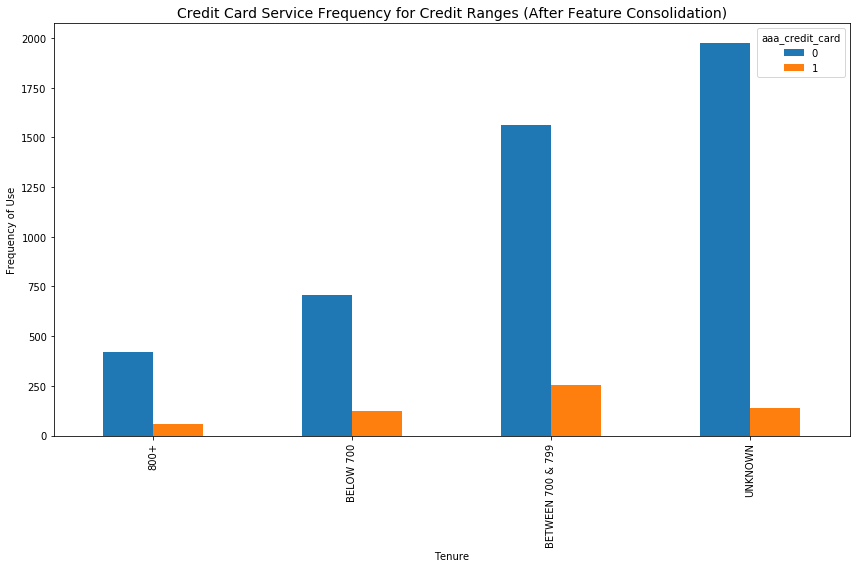

In [28]:
group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
group2 = ['700-749', '750-799']
group3 = ['800+']
for i in group1:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
for i in group2:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
for i in group3:
    df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])

pd.crosstab(df_household.credit_ranges,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Credit Ranges (After Feature Consolidation)')
plt.xlabel('Tenure')
plt.ylabel('Frequency of Use')
plt.savefig('credit_ranges_use_cc_feat')

In [29]:
# Education
df_household.education.value_counts()

UNKNOWN              2930
SOME COLLEGE          923
HIGH SCHOOL           850
COMPLETED COLLEGE     485
GRADUATED SCHOOL       52
Name: education, dtype: int64

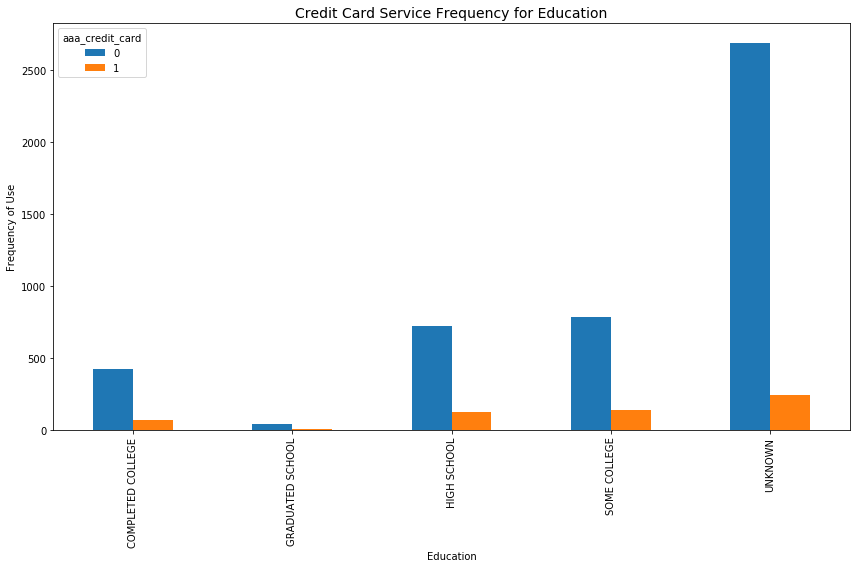

In [30]:
# graph education
pd.crosstab(df_household.education,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_cc')

# Outcomes
The frequency of credit card use depend heavily on education. Will consolidate graduate with completed collegue

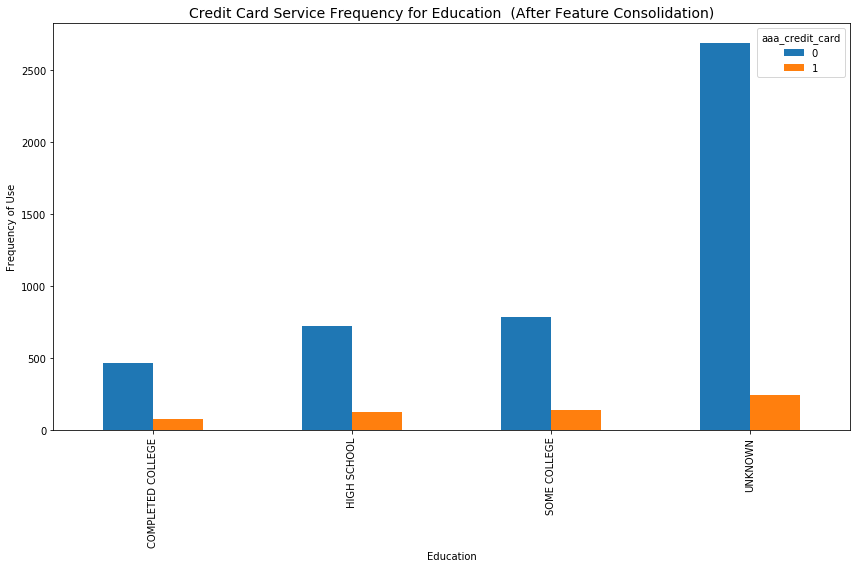

In [31]:
# graph education
df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
pd.crosstab(df_household.education,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Education  (After Feature Consolidation)')
plt.xlabel('Education')
plt.ylabel('Frequency of Use')
plt.savefig('education_use_cc_feat')

In [32]:
# Generation
df_household.generation.value_counts()

POST-WAR (< 1948)             3608
BABY BOOMERS (1948 - 1968)    1149
UNKNOWN                        352
GENERATION X (1969 - 1980)      78
MILLENIALS (1981 - 1993)        48
GENERATION Z (1994 - 2010)       5
Name: generation, dtype: int64

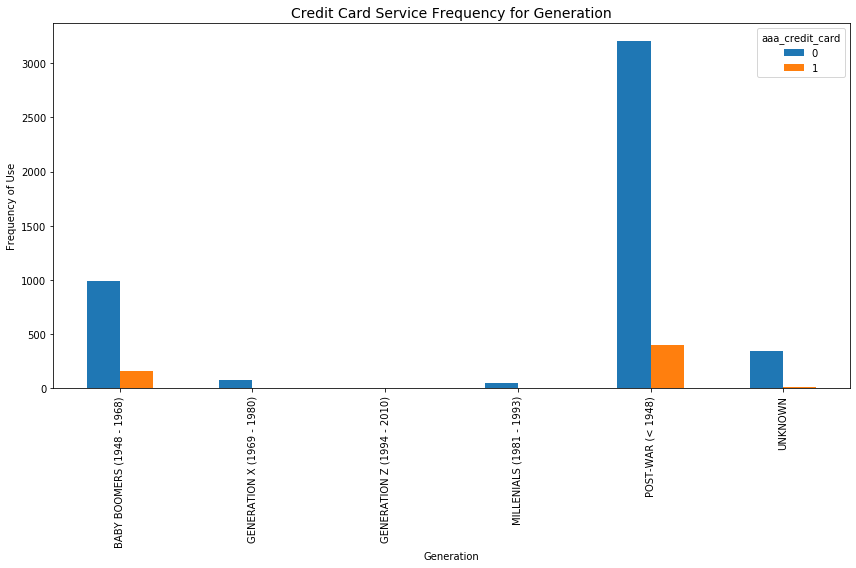

In [33]:
# graph Generation
pd.crosstab(df_household.generation,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Generation')
plt.xlabel('Generation')
plt.ylabel('Frequency of Use')
plt.savefig('generation_use_cc')

In [34]:
# Race
df_household.race.value_counts()

UNKNOWN                                   2075
CAUCASION / WHITE - EUROPEAN              1448
CAUCASION / WHITE - ENGLISH                777
CAUCASION / WHITE - WHITE NON-AMERICAN     293
CAUCASION / WHITE - UNKNOWN                127
MIDDLE EASTERN - ARAB                      125
HISPANIC - HISPANIC ORIGIN                 106
CAUCASION / WHITE - EASTERN EUROPEAN        95
HISPANIC - PORTUGUESE ORIGIN                86
CAUCASION / WHITE - JEWISH                  23
ASIAN - CHINESE                             20
CAUCASION / WHITE - GREEK                   16
ASIAN - UNKNOWN                             12
AFRICAN AMERICAN - AFRICAN ORIGIN           10
AMERICAN INDIAN                              7
ASIAN - JAPANESE                             6
ASIAN - INDIAN                               6
MIDDLE EASTERN - EGYPTIAN                    5
CAUCASION / WHITE - DUTCH                    2
ASIAN - ORIENTAL                             1
Name: race, dtype: int64

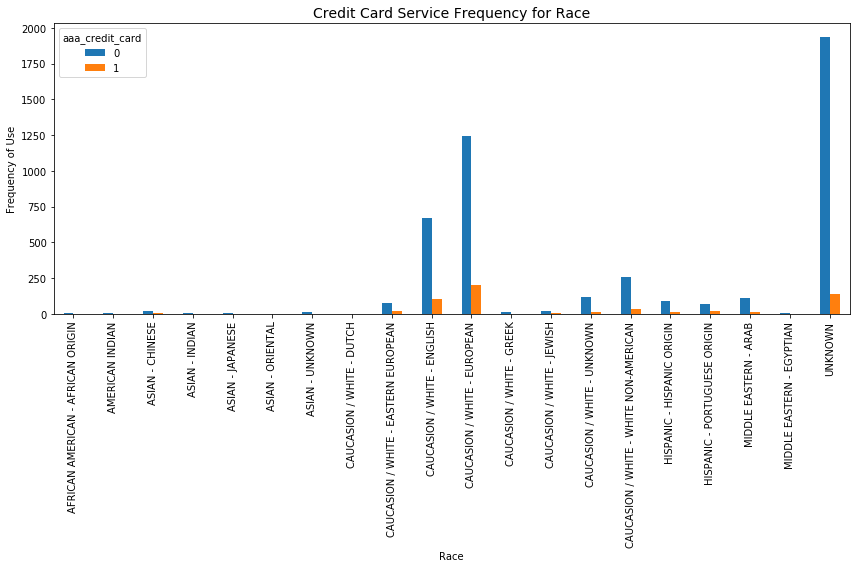

In [35]:
# graph race
pd.crosstab(df_household.race,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_cc')

# Observations
The frequency of credit card use depend heavily on race being caucasion- white group the predominant. 
I Will consolidate them in more similar groups
* a) Caucasion - White
* b) Hispanic
* c) Asian
* d) Arabs
* e) America Africans / Indians

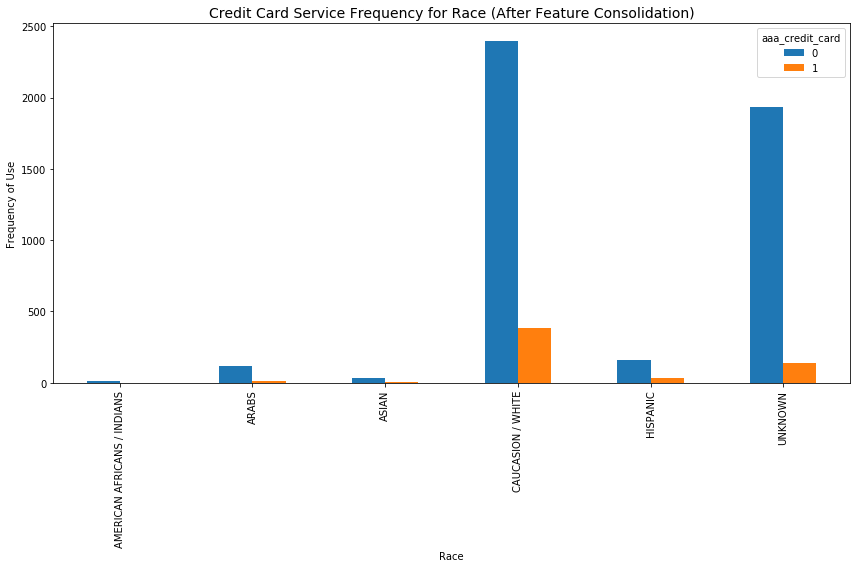

In [36]:
group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

for i in group1:
    df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
for i in group2:
    df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
for i in group3:
    df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
for i in group4:
    df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
for i in group5:
    df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

pd.crosstab(df_household.race,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Race (After Feature Consolidation)')
plt.xlabel('Race')
plt.ylabel('Frequency of Use')
plt.savefig('race_use_cc_feat')

In [37]:
# Home Owner
df_household.home_owner.value_counts()

HOME OWNER             2991
UNKNOWN                2111
RENTER                  129
PROBABLE RENTER           6
PROBABLE HOME OWNER       3
Name: home_owner, dtype: int64

# Outcomes
The frequency of credit card use depend heavily on home_owner.  Will leave consolidate probable renter with RENTER and probable home owner with home owner 

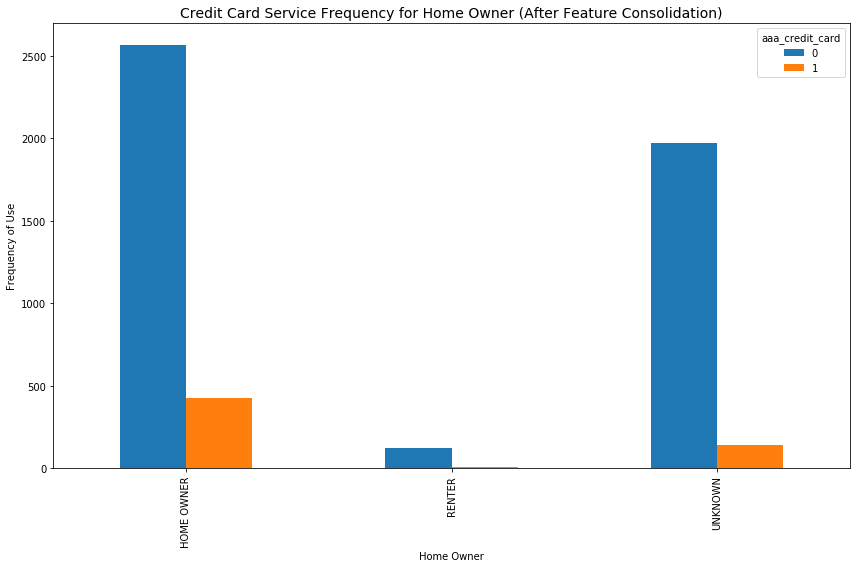

In [38]:
# Home Owner
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])

pd.crosstab(df_household.home_owner,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Home Owner (After Feature Consolidation)')
plt.xlabel('Home Owner')
plt.ylabel('Frequency of Use')
plt.savefig('home_owner_use_cc_feat')

In [39]:
# Cancel reason
df_household.cancel_reason.value_counts()

UNKNOWN                               3502
NON-PAYMENT                            833
DECEASED                               433
NO LONGER DRIVING                      157
MEMBERS REQUEST                        122
CANCELLED DO NOT RENEW                  53
DATA PROBLEM                            36
DUP MEMBERSHIP                          27
TRANSFER MEMBER                         20
DO NOT RENEW                            19
MOVED OUT OF TERR                       11
TRANSFER MEMBER SUSPEND                 10
CANCELLED MBRS REQUEST                   3
ERS DECLINE CC                           3
BAD ADD SET BY PO ACS                    2
HEALTH ISSUE                             2
*BAD CHECKS*                             2
PO RETURN                                1
ERS CNCL MSHIP PROGRAM                   1
MANAGEMENT REQUEST                       1
NONCOMPLIANT AGE                         1
CANCEL PROCESS - FUTURE CANCEL DNR       1
Name: cancel_reason, dtype: int64

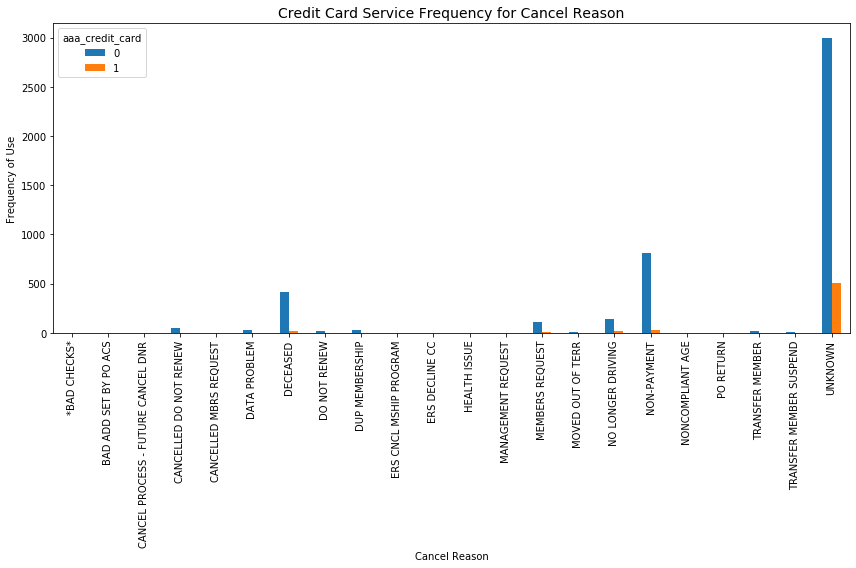

In [40]:
# graph Cancel Reason
pd.crosstab(df_household.cancel_reason,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Cancel Reason')
plt.xlabel('Cancel Reason')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_cc')

# Observation
This Cancel Reason feature does not seems to be important to weather member choose or not CC. Even though, for instance those member that their suscription was cancelled or CC rejected, there might be an oportunity to get a CC if credit is available to them.  Will consolidate the reason in three main groups:
* a) PAYMENT ISSUES
* b) MEMBER ISSUES
* c) DATA/AAA ISSUES

UKNOWN will be replaced by 'NOT CANCELLED'  It is the largest group and a potential to customer.

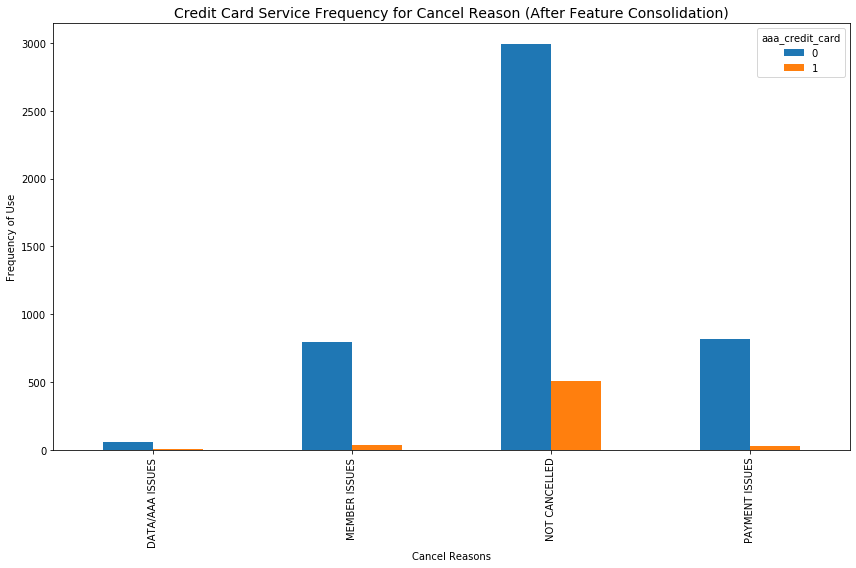

In [41]:
group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
          'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
          'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
         ]
group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

for i in group1:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
for i in group2:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
for i in group3:
    df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

df_household['cancel_reason']=np.where(df_household['cancel_reason']== 'UNKNOWN', 'NOT CANCELLED', df_household['cancel_reason'])
pd.crosstab(df_household.cancel_reason,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Cancel Reason (After Feature Consolidation)')
plt.xlabel('Cancel Reasons')
plt.ylabel('Frequency of Use')
plt.savefig('cancel_reason_use_cc_feat')

In [42]:
# mosaic_household
df_household.mosaic_household.value_counts()

UNKNOWN                       1516
AGING IN PLACE                 691
SILVER SOPHISTICATES           330
REAPING REWARDS                245
NO PLACE LIKE HOME             231
ROOTED FLOWER POWER            221
TOWN ELDERS                    199
SENIOR DISCOUNTS               180
AGING OF AQUARIUS              160
SETTLED IN SUBURBIA            139
FULL POCKETS  EMPTY NESTS      114
DIGITAL DEPENDENTS             104
BOHEMIAN GROOVE                 70
BLUE COLLAR COMFORT             69
FAST TRACK COUPLES              69
PLATINUM PROSPERITY             64
FAMILY FUN-TASTIC               61
AMERICAN ROYALTY                57
PROGRESSIVE POTPOURRI           50
BOOMERS AND BOOMERANGS          45
STATUS SEEKING SINGLES          44
GOLF CARTS AND GOURMETS         42
BIRKENSTOCKS AND BEEMERS        41
UNSPOILED SPLENDOR              40
PICTURE PERFECT FAMILIES        38
MID-SCALE MEDLEY                38
SETTLED AND SENSIBLE            27
COUPLES WITH CLOUT              27
TOUGH TIMES         

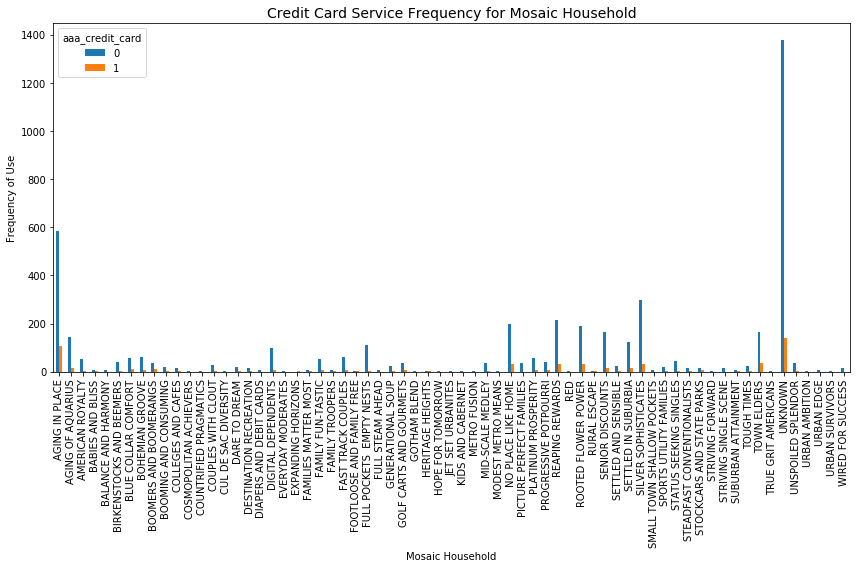

In [43]:
# graph Mosaic household
pd.crosstab(df_household.mosaic_household,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Mosaic Household')
plt.xlabel('Mosaic Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_household_use_cc')

In [44]:
# mosaic_household
df_household.mosaic_global_household.value_counts()

UNKNOWN                      1516
COMFORTABLE RETIREMENT       1177
BOURGEOIS PROSPERITY          838
ROUTINE SERVICE WORKERS       539
HARD WORKING BLUE COLLAR      264
CAREER AND FAMILY             241
LOW INCOME ELDERS             230
POST INDUSTRIAL SURVIVORS     230
METROPOLITAN STRUGGLERS       138
SOPHISTICATED SINGLES          64
RURAL INHERITANCE               3
Name: mosaic_global_household, dtype: int64

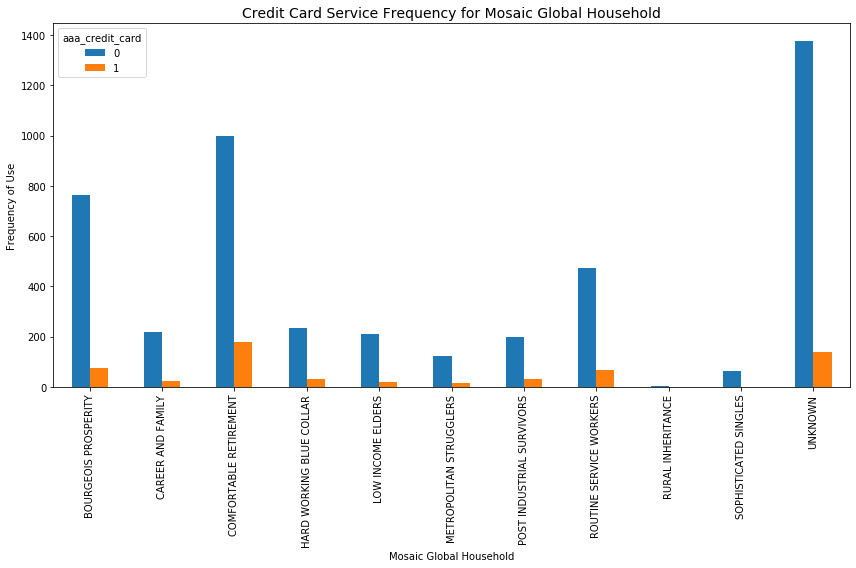

In [45]:
# graph Mosaic Global household
pd.crosstab(df_household.mosaic_global_household,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Mosaic Global Household')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_cc')

# Observation
Reviewing the graph above, these three groups cann be consolidated in:
* a) METROPOLITAN STRUGGLERS into ROUTINE SERVICE WORKERS
* b) SOPHISTICATED SINGLES into BOURGEOIS PROSPERITY
* c) RURAL INHERITANCE into CAREER AND FAMILY
* d) POST INDUSTRIAL SURVIVORS into ROUTINE SERVICE WORKERS

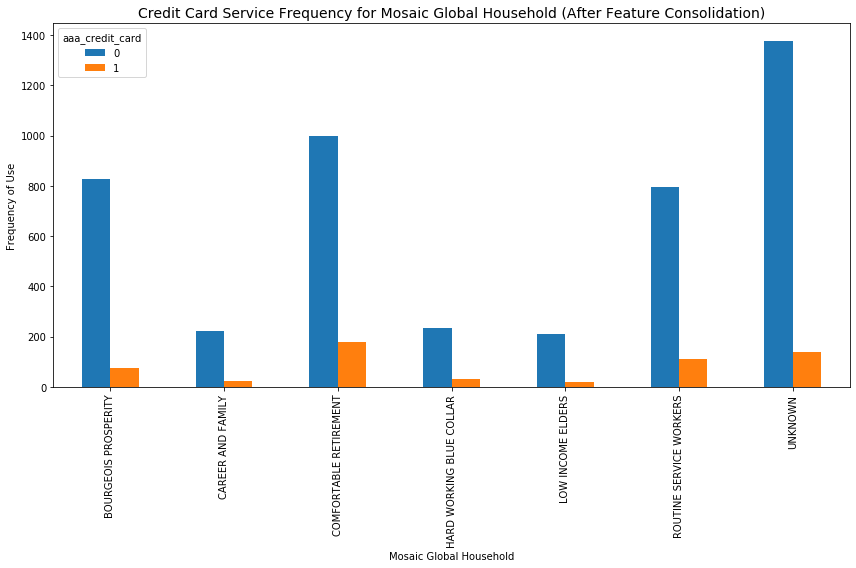

In [46]:
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                 'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                )

df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                 'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                )
df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

pd.crosstab(df_household.mosaic_global_household,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Mosaic Global Household (After Feature Consolidation)')
plt.xlabel('Mosaic Global Household')
plt.ylabel('Frequency of Use')
plt.savefig('mosaic_global_household_use_cc_feat')

In [47]:
# kcl_b_ind_mosaicsgrouping
df_household.kcl_b_ind_mosaicsgrouping.value_counts()

UNKNOWN                     1516
AUTUMN YEARS                 722
GOLDEN YEAR GUARDIANS        628
BOOMING WITH CONFIDENCE      577
THRIVING BOOMERS             385
BLUE SKY BOOMERS             242
POWER ELITE                  191
SURBURBAN STYLE              174
SINGLES AND STARTERS         158
FAMILY UNION                 116
MIDDLE CLASS MELTING POT     108
FLOURISHING FAMILIES          94
SIGNIFICANT SINGLES           89
PROMISING FAMILIES            80
YOUNG CITY SOLOS              50
CULTURAL CONNECTIONS          44
ECONOMIC CHALLENGES           34
ASPIRATIONAL FUSION           22
FAMILIES IN MOTION             8
PASTORAL PRIDE                 2
Name: kcl_b_ind_mosaicsgrouping, dtype: int64

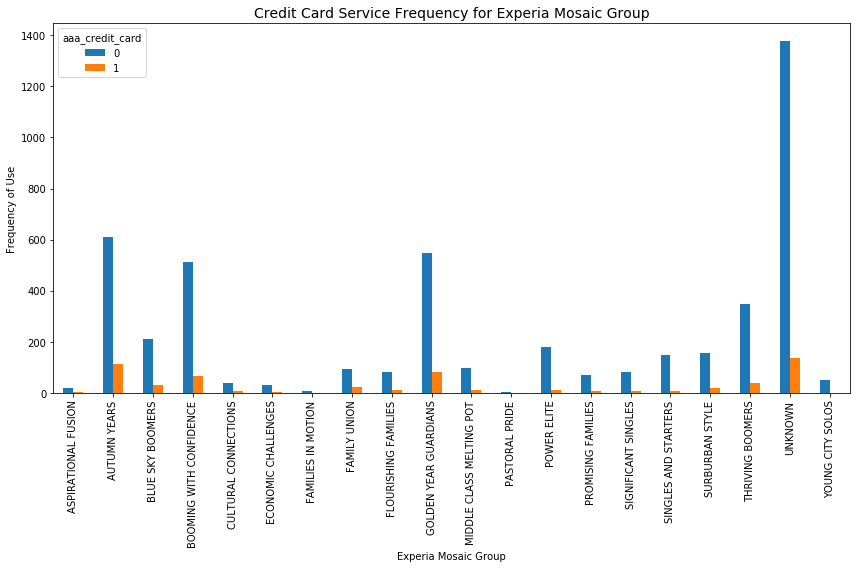

In [48]:
# graph kcl_b_ind_mosaicsgrouping
pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Experia Mosaic Group')
plt.xlabel('Experia Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_cc')

# Observation
Reviewing the graph above, there are five dominant group here
* a) GOLDEN YEARS - retired people
* b) BOOMING - well established families
* c) POWER ELITE - powerufull wealth people
* d) FAMILY - middle class families
* e) Singles - singles or single moms.

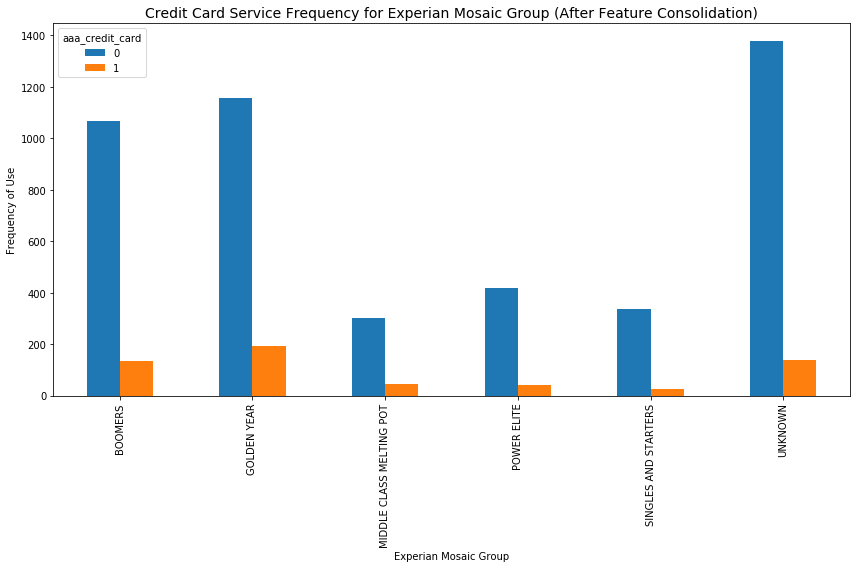

In [49]:
group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
          'PASTORAL PRIDE']
group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
         'ASPIRATIONAL FUSION']
for i in group1:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group2:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group3:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group4:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
for i in group5:
    df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])

pd.crosstab(df_household.kcl_b_ind_mosaicsgrouping,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Experian Mosaic Group (After Feature Consolidation)')
plt.xlabel('Experian Mosaic Group')
plt.ylabel('Frequency of Use')
plt.savefig('kcl_b_ind_mosaicsgrouping_use_cc_feat')

In [50]:
# Vehicle Manufacturer
df_household.sc_vehicle_manufacturer_name.value_counts()

UNKNOWN            2252
TOYOTA              616
FORD                332
HONDA               319
CHEVROLET           186
HYUNDAI             161
NISSAN              147
BUICK               126
SUBARU              116
JEEP                 82
DODGE                75
MERCURY              73
LEXUS                73
CHRYSLER             68
VOLKSWAGEN           68
VOLVO                61
MERCEDES-BENZ        53
KIA                  45
GMC                  39
MAZDA                38
LINCOLN              38
CADILLAC             38
ACURA                31
SATURN               29
PONTIAC              26
OLDSMOBILE           22
BMW                  20
SAAB                 19
AUDI                 16
INFINITI             14
SCION                 9
LAND ROVER            8
MITSUBISHI            7
RAM                   5
MINI                  4
PLYMOUTH              4
SUZUKI                4
JAGUAR                3
PORSCHE               3
GEO                   2
BICYCLE               2
HARLEY DAVIDSON 

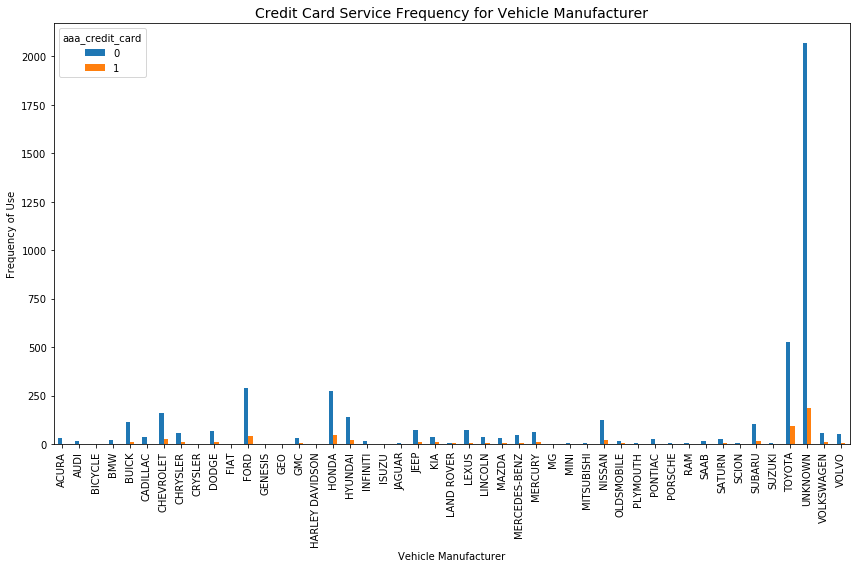

In [51]:
# graph Vehicle manufacturer
pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Vehicle Manufacturer')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_cc')

# Observation
Reviewing the graph above, there are four main group of car.  

* a) Standard for small families, and young professional, 
* b) Middle End - Middle class families and middle management
* c) High End - Success and upper management or people above 55 years no debts and no kids at school

Going to group the vehicle manufacturer in those three groups.

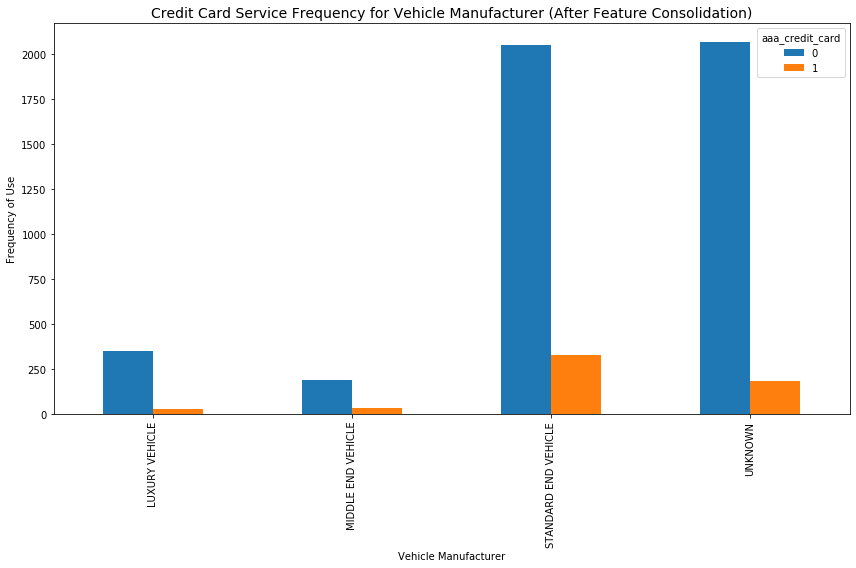

In [52]:
group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']
          
group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
          'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

for i in group1:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group2:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
for i in group3:
    df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])


pd.crosstab(df_household.sc_vehicle_manufacturer_name,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Vehicle Manufacturer (After Feature Consolidation)')
plt.xlabel('Vehicle Manufacturer')
plt.ylabel('Frequency of Use')
plt.savefig('vehicle_manufacturer_use_cc_feat')

In [53]:
# Occupation Code
df_household.occupation_code.value_counts()

UNKNOWN                            4178
RETIRED                             256
PROFESSIONAL/TECHNICAL              140
UPPER MANAGEMENT/EXECUTIVE           82
NURSE                                78
SKILLEDTRADE/MACHINE/LABORER         70
CLERICAL/OFFICE                      68
TEACHER/EDUCATOR                     67
MIDDLE MANAGEMENT                    65
SALES/MARKETING                      33
BEAUTY                               22
REAL ESTATE                          21
SELF EMPLOYED                        17
ATTORNEYS                            14
EXECUTIVE/ADMINISTRATOR              13
HEALTH SERVICES                      11
PHARMACIST                            9
COUNSELORS                            8
RETAIL SALES                          7
ACCOUNTANTS/CPA                       7
DENTIST/DENTAL HYGIENIST              7
ARCHITECTS                            6
CIVIL SERVANT                         6
COMPUTER PROFESSIONAL                 6
PROFESSIONAL DRIVER                   6


In [54]:
df_household.occupation_group.value_counts()

UNKNOWN                             3030
RETIRED - INFERRED                   771
PROFESSIONAL - KNOWN                 354
RETIRED - KNOWN                      256
MANAGEMENT - KNOWN                   177
BLUE COLLAR - KNOWN                   77
OTHER - INFERRED                      71
MANAGEMENT - INFERRED                 70
OFFICE ADMINISTRATION - KNOWN         68
BLUE COLLAR - INFERRED                66
SALES - KNOWN                         61
OFFICE ADMINISTRATION - INFERRED      60
PROFESSIONAL - INFERRED               56
OTHER - KNOWN                         51
TECHNICAL - INFERRED                  34
SALES - INFERRED                      20
TECHNICAL - KNOWN                     18
Name: occupation_group, dtype: int64

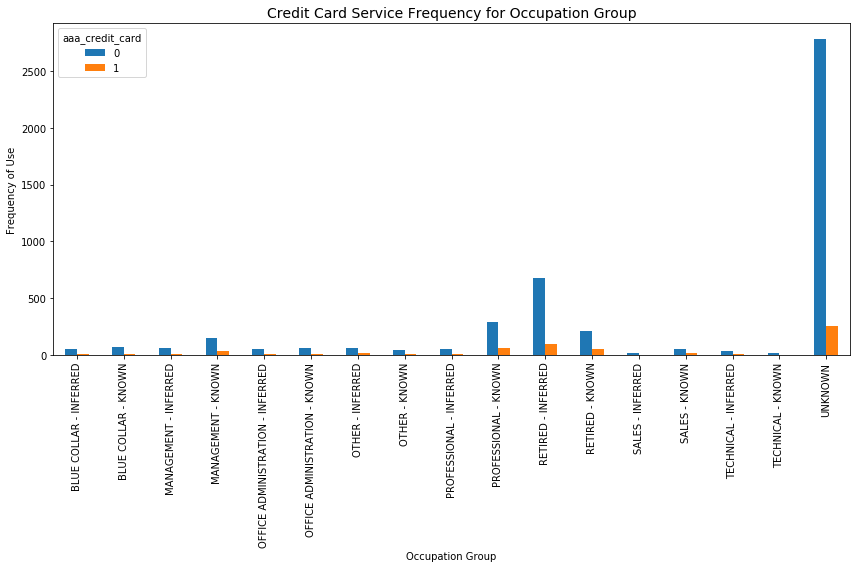

In [55]:
# graph ocuppation group
pd.crosstab(df_household.occupation_group,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Occupation Group')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_cc')

# Observation
Reviewing the graph above, there are 4 prodominat group
* a) PROFESSIONAL
* b) MANAGEMENT
* c) RETIRED
* d) OTHERS

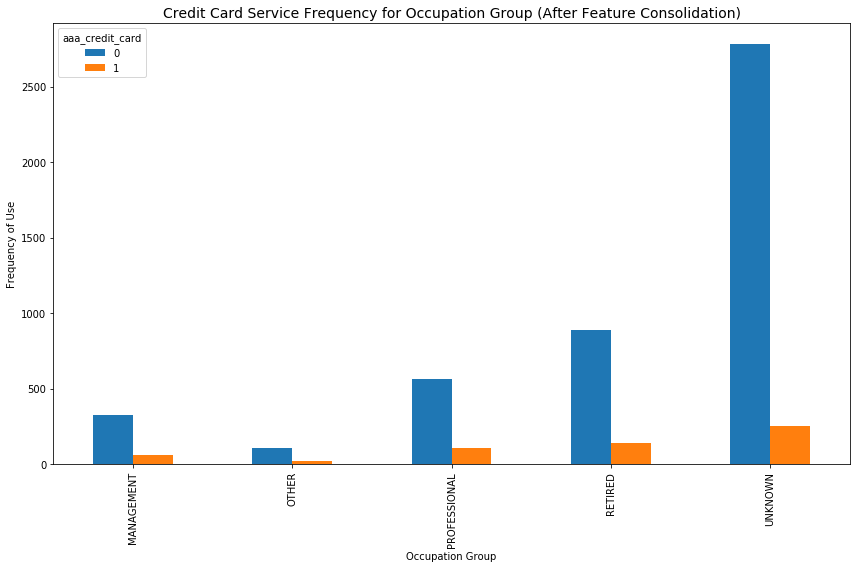

In [56]:
group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

for i in group1:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
for i in group2:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
for i in group3:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
for i in group4:
    df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])


pd.crosstab(df_household.occupation_group,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Occupation Group (After Feature Consolidation)')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('occupation_group_use_cc_feat')

In [57]:
# graph occupant type
df_household.occupant_type.value_counts()

UNKNOWN      5044
HOMEOWNER     137
RENTER         59
Name: occupant_type, dtype: int64

In [59]:
# graph member status
df_household.member_status.value_counts()

ACTIVE       3182
CANCELLED    1738
PENDING       320
Name: member_status, dtype: int64

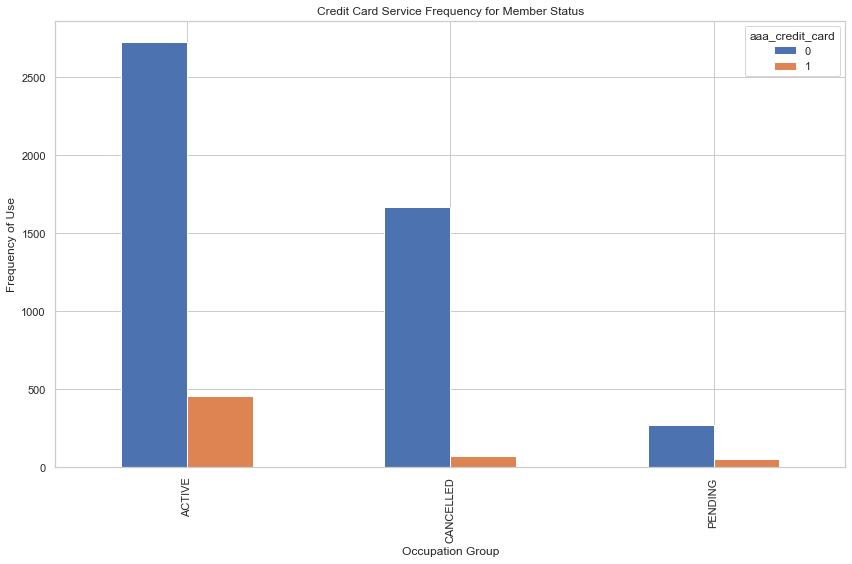

In [83]:
# graph member status group
pd.crosstab(df_household.member_status,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Member Status')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency of Use')
plt.savefig('member_status_use_cc')

In [94]:
# graph Auto Insurance
df_household.aaa_auto_insurance.value_counts()

0    3799
1    1441
Name: aaa_auto_insurance, dtype: int64

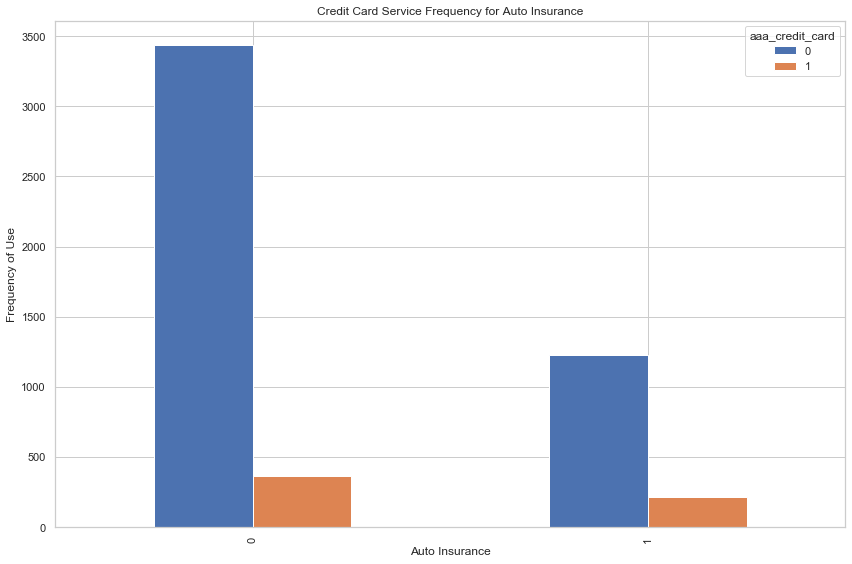

In [93]:
# graph Financial service
pd.crosstab(df_household.aaa_auto_insurance,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Auto Insurance')
plt.xlabel('Auto Insurance')
plt.ylabel('Frequency of Use')
plt.savefig('autoinsurance_use_cc')

In [91]:
# graph Financial service
df_household.aaa_financial_service.value_counts()

0    4872
1     368
Name: aaa_financial_service, dtype: int64

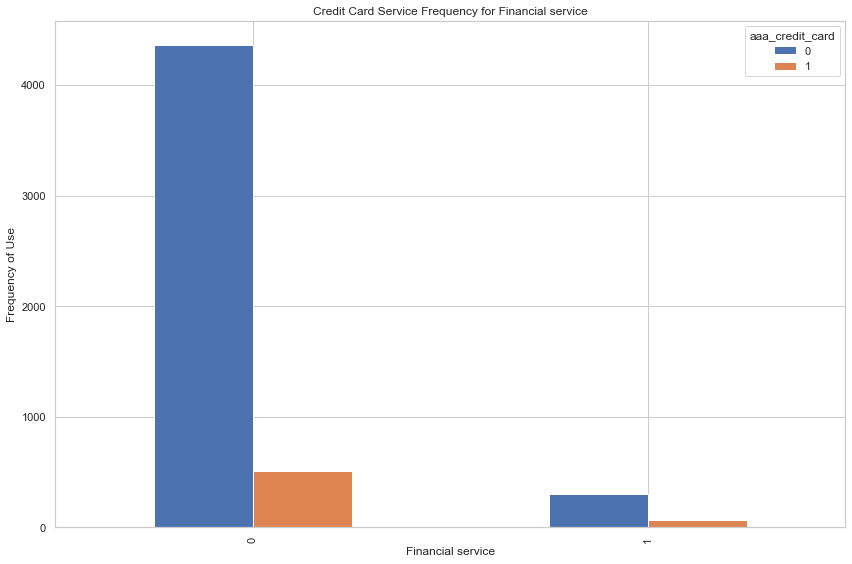

In [92]:
# graph Financial service
pd.crosstab(df_household.aaa_financial_service,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Financial service')
plt.xlabel('Financial service')
plt.ylabel('Frequency of Use')
plt.savefig('financial_service_use_cc')

In [88]:
# graph home_equity
df_household.aaa_home_equity.value_counts()

0    5234
1       6
Name: aaa_home_equity, dtype: int64

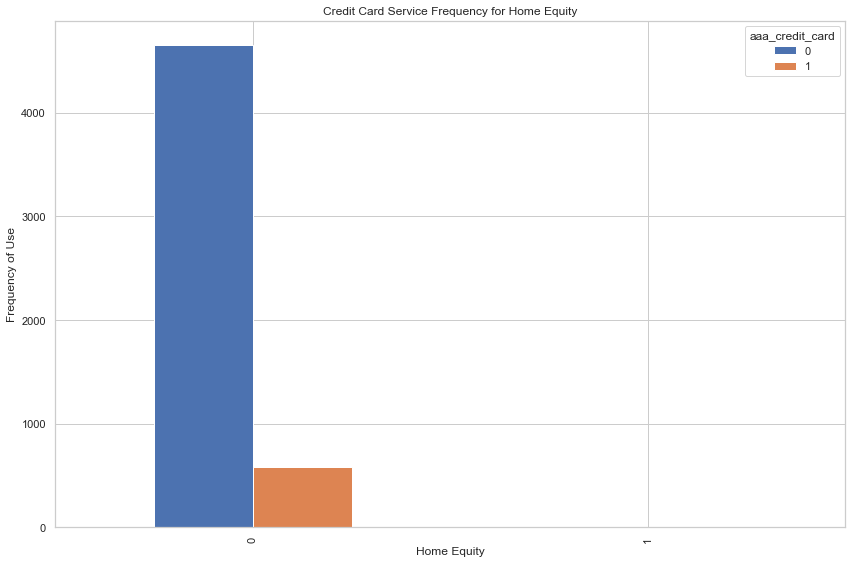

In [90]:
# graph home_equity
pd.crosstab(df_household.aaa_home_equity,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Home Equity')
plt.xlabel('Home Equity')
plt.ylabel('Frequency of Use')
plt.savefig('home_equity_use_cc')

In [85]:
# graph deposit
df_household.aaa_deposit.value_counts()

0    5212
1      28
Name: aaa_deposit, dtype: int64

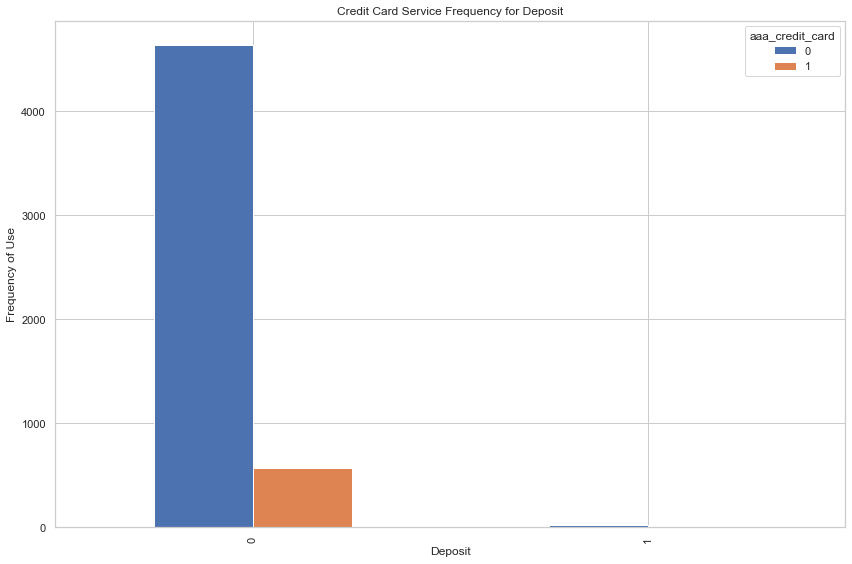

In [86]:
# graph Mortgage group
pd.crosstab(df_household.aaa_deposit,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Deposit')
plt.xlabel('Deposit')
plt.ylabel('Frequency of Use')
plt.savefig('deposit_use_cc')

In [81]:
# graph aaa_mortgage
df_household.aaa_mortgage.value_counts()

0    5229
1      11
Name: aaa_mortgage, dtype: int64

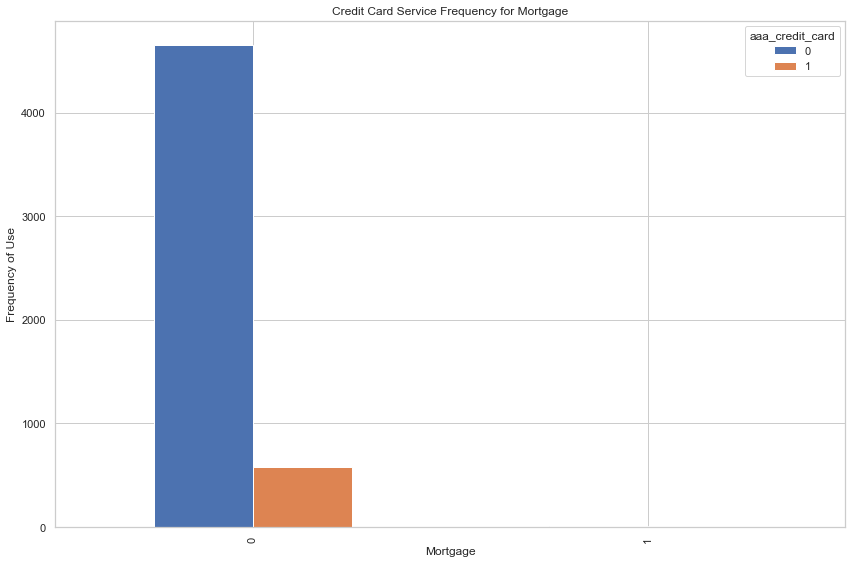

In [84]:
# graph Mortgage group
pd.crosstab(df_household.aaa_mortgage,df_household.aaa_credit_card).plot(kind='bar', figsize=(12,8))
plt.title('Credit Card Service Frequency for Mortgage')
plt.xlabel('Mortgage')
plt.ylabel('Frequency of Use')
plt.savefig('mortgage_use_cc')

# Model to predict Credit Card Service Usage by household key

Previous Columns Used
cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'cancel_reason',
                       'race', 'home_owner', 'dwelling_type', 'mosaic_global_household',
                       'plus_indicator_description', 'gender', 'mosaic_household',
                       'kcl_b_ind_mosaicsgrouping', 'sc_vehicle_manufacturer_name'
                       occupation_code, occupation_group, occupant_type, vehicle, sc_vehicle_model_name

feature_cols = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                    'total_calls', 'total_member_cost', 'total_cost'

# Final Observation

Based on the previous anlysis, these are the most important feature:
* income
* tenure
* credit_ranges
* education
* generation
* race
* home_owner
* cancel_reason
* mosaic_global_household
* plus_indicator_description
* Gender
* kcl_b_ind_mosaicsgrouping
* sc_vehicle_manufacturer_name
* occupation_group


In [115]:
def reiniciar(df_household):
    df_household = read_data('household_view.csv')
    
    # Regroup Group Income
    group1 = ['UNDER 10K', '20-29,999', '30-39,999']
    group2 = ['40-49,999', '50-59,999', '60-69,999', '70-79,999', '80-89,999', '90-99,999']
    group3 = ['100-149,999', '150 - 174,999', '175 - 199,999', '200 - 249,999', '250K+' ]
    for i in group1:
        df_household['income']=np.where(df_household['income']== i, 'UNDER 39,999', df_household['income'])
    for i in group2:
        df_household['income']=np.where(df_household['income']== i, '40 - 99,999', df_household['income'])
    for i in group3:
        df_household['income']=np.where(df_household['income']== i, '100k+', df_household['income'])
    
    # Regroup tenures
    group1 = ['BETWEEN 6 & 10 YEARS', 'BETWEEN 11 & 15 YEARS', 
          'BETWEEN 16 & 20 YEARS', 'BETWEEN 1 & 5 YEARS', '< 1 YEAR']
    group2 = ['BETWEEN 31 & 40 YEARS', 'BETWEEN 21 & 30 YEARS']
    group3 = ['+40 YEARS']
    for i in group1:
        df_household['tenure']=np.where(df_household['tenure']== i, 'UNDER 20 YEARS', df_household['tenure'])
    for i in group2:
        df_household['tenure']=np.where(df_household['tenure']== i, 'BETWEEN 21 & 40 YEARS', df_household['tenure'])
    for i in group3:
        df_household['tenure']=np.where(df_household['tenure']== i, '+40 YEARS', df_household['tenure'])
    
    # Regroup credit ranges
    group1 = ['499 & LESS', '500-549','550-599','600-649', '650-699']
    group2 = ['700-749', '750-799']
    group3 = ['800+']
    for i in group1:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BELOW 700', df_household['credit_ranges'])
    for i in group2:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, 'BETWEEN 700 & 799', df_household['credit_ranges'])
    for i in group3:
        df_household['credit_ranges']=np.where(df_household['credit_ranges']== i, '800+', df_household['credit_ranges'])
    
    # Regroup Education
    df_household['education']=np.where(df_household['education'] =='GRADUATED SCHOOL', 
                                   'COMPLETED COLLEGE', df_household['education']
                                  )
    # Regroup Race
    group1 = ['CAUCASION / WHITE - EUROPEAN', 'CAUCASION / WHITE - ENGLISH', 'CAUCASION / WHITE - WHITE NON-AMERICAN',
          'CAUCASION / WHITE - UNKNOWN', 'CAUCASION / WHITE - EASTERN EUROPEAN', 'CAUCASION / WHITE - JEWISH',
          'CAUCASION / WHITE - GREEK', 'CAUCASION / WHITE - DUTCH'
         ]
    group2 = ['HISPANIC - HISPANIC ORIGIN', 'HISPANIC - PORTUGUESE ORIGIN']
    group3 = ['ASIAN - CHINESE', 'ASIAN - UNKNOWN', 'ASIAN - JAPANESE', 'ASIAN - INDIAN', 'ASIAN - ORIENTAL']
    group4 = ['MIDDLE EASTERN - ARAB', 'MIDDLE EASTERN - EGYPTIAN']
    group5 = ['AFRICAN AMERICAN - AFRICAN ORIGIN', 'AMERICAN INDIAN']

    for i in group1:
        df_household['race']=np.where(df_household['race']== i, 'CAUCASION / WHITE', df_household['race'])
    for i in group2:
        df_household['race']=np.where(df_household['race']== i, 'HISPANIC', df_household['race'])
    for i in group3:
        df_household['race']=np.where(df_household['race']== i, 'ASIAN', df_household['race'])
    for i in group4:
        df_household['race']=np.where(df_household['race']== i, 'ARABS', df_household['race'])
    for i in group5:
        df_household['race']=np.where(df_household['race']== i, 'AMERICAN AFRICANS / INDIANS', df_household['race'])

    # Regroup Home Owner
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE RENTER', 'RENTER', df_household['home_owner'])
    df_household['home_owner']=np.where(df_household['home_owner']== 'PROBABLE HOME OWNER', 'HOME OWNER', df_household['home_owner'])
    
    # Regroup Cancel reason
    group1 = ['NON-PAYMENT', 'ERS DECLINE CC', 'BAD ADD SET BY PO ACS', '*BAD CHECKS*', 
         ]
    group2 = ['DECEASED', 'NO LONGER DRIVING', 'MEMBERS REQUEST', 'CANCELLED DO NOT RENEW', 'TRANSFER MEMBER',
              'DO NOT RENEW', 'MOVED OUT OF TERR', 'TRANSFER MEMBER SUSPEND', 'CANCELLED MBRS REQUEST',
              'HEALTH ISSUE', 'NONCOMPLIANT AGE', 'PO RETURN'
             ]
    group3 = ['DATA PROBLEM','DUP MEMBERSHIP','ERS CNCL MSHIP PROGRAM','MANAGEMENT REQUEST', 'CANCEL PROCESS - FUTURE CANCEL DNR']

    for i in group1:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'PAYMENT ISSUES', df_household['cancel_reason'])
    for i in group2:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'MEMBER ISSUES', df_household['cancel_reason'])
    for i in group3:
        df_household['cancel_reason']=np.where(df_household['cancel_reason']== i, 'DATA/AAA ISSUES', df_household['cancel_reason'])

    # Regroup Mosaic Global household
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'METROPOLITAN STRUGGLERS', 
                                                 'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'SOPHISTICATED SINGLES', 
                                                     'BOURGEOIS PROSPERITY', df_household['mosaic_global_household']
                                                    )

    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'RURAL INHERITANCE', 
                                                     'CAREER AND FAMILY', df_household['mosaic_global_household']
                                                    )
    df_household['mosaic_global_household']=np.where(df_household['mosaic_global_household']== 'POST INDUSTRIAL SURVIVORS', 
                                                     'ROUTINE SERVICE WORKERS', df_household['mosaic_global_household']
                                                    )
    # Regroup Experian Group
    group1 = ['AUTUMN YEARS', 'GOLDEN YEAR GUARDIANS']
    group2 = ['BOOMING WITH CONFIDENCE', 'THRIVING BOOMERS', 'BLUE SKY BOOMERS']
    group3 = ['POWER ELITE', 'SURBURBAN STYLE', 'FLOURISHING FAMILIES']
    group4 = ['FAMILY UNION', 'MIDDLE CLASS MELTING POT', 'PROMISING FAMILIES', 'ECONOMIC CHALLENGES', 'FAMILIES IN MOTION',
              'PASTORAL PRIDE']
    group5 = ['SINGLES AND STARTERS', 'SIGNIFICANT SINGLES', 'YOUNG CITY SOLOS', 'CULTURAL CONNECTIONS',
             'ASPIRATIONAL FUSION']
    for i in group1:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'GOLDEN YEAR', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group2:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'BOOMERS', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group3:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'POWER ELITE', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group4:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'MIDDLE CLASS MELTING POT', df_household['kcl_b_ind_mosaicsgrouping'])
    for i in group5:
        df_household['kcl_b_ind_mosaicsgrouping']=np.where(df_household['kcl_b_ind_mosaicsgrouping']== i, 'SINGLES AND STARTERS', df_household['kcl_b_ind_mosaicsgrouping'])
    
    # Regroup Vehicle Manufaturer
    group1 = [ 'TOYOTA', 'FORD', 'HONDA', 'CHEVROLET', 'HYUNDAI', 'NISSAN', 'BUICK', 'SUBARU', 'SUZUKI',
         'DODGE', 'CHRYSLER', 'VOLKSWAGEN','KIA', 'MAZDA', 'SATURN', 'PONTIAC', 'SCION', 'MITSUBISHI',
          'GEO', 'CRYSLER', 'MG', 'FIAT', 'BICYCLE', 'ISUZU']
    group2 = ['JEEP', 'MERCURY','GMC', 'OLSMOBILE', 'RAM', 'PLYMOUTH', 'GENESIS', 'OLDSMOBILE']

    group3 = ['LEXUS', 'VOLVO', 'MERCEDES-BENZ', 'CADILLAC','LINCOLN', 'ACURA', 'BMW', 'SAAB', 'AUDI', 'INFINITI',
              'LAND ROVER', 'MINI', 'JAGUAR', 'PORSCHE', 'HARLEY DAVIDSON']

    for i in group1:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'STANDARD END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group2:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'MIDDLE END VEHICLE', df_household['sc_vehicle_manufacturer_name'])
    for i in group3:
        df_household['sc_vehicle_manufacturer_name']=np.where(df_household['sc_vehicle_manufacturer_name']== i, 'LUXURY VEHICLE', df_household['sc_vehicle_manufacturer_name'])

    # Regroup Occupation Group
    group1 = ['PROFESSIONAL - KNOWN', 'PROFESSIONAL - INFERRED', 'OFFICE ADMINISTRATION - KNOWN',
         'SALES - KNOWN', 'OFFICE ADMINISTRATION - INFERRED', 'TECHNICAL - INFERRED',
         'SALES - INFERRED', 'TECHNICAL - KNOWN']
    group2 = ['MANAGEMENT - KNOWN', 'BLUE COLLAR - KNOWN', 'MANAGEMENT - INFERRED', 'BLUE COLLAR - INFERRED']
    group3 = ['RETIRED - INFERRED', 'RETIRED - KNOWN']
    group4 = ['OTHER - INFERRED', 'OTHER - KNOWN']

    for i in group1:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'PROFESSIONAL', df_household['occupation_group'])
    for i in group2:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'MANAGEMENT', df_household['occupation_group'])
    for i in group3:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'RETIRED', df_household['occupation_group'])
    for i in group4:
        df_household['occupation_group']=np.where(df_household['occupation_group']== i, 'OTHER', df_household['occupation_group'])

    
    
    return df_household

In [153]:
df_household.groupby(by='aaa_credit_card')['total_cost'].mean()

aaa_credit_card
0   122.1690
1   155.0735
Name: total_cost, dtype: float64

In [154]:
df_household.groupby(by='aaa_credit_card')['total_calls'].mean()

aaa_credit_card
0   7.4348
1   9.6920
Name: total_calls, dtype: float64

In [155]:
df_household.groupby(by='aaa_credit_card')['total_member_cost'].mean()

aaa_credit_card
0   397.5624
1   502.1633
Name: total_member_cost, dtype: float64

In [190]:
# Reload data to conduct another experiment
df_household = reiniciar(df_household)
df_household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 65 columns):
household_key                        int64
income                               object
member_status                        object
state_grouped                        object
credit_ranges                        object
cancel_reason                        object
renew_method                         object
plus_indicator_description           object
zip                                  int64
sc_vehicle_manufacturer_name         object
sc_vehicle_model_name                object
race                                 object
home_owner                           object
education                            object
dwelling_type                        object
gender                               object
occupation_code                      object
occupation_group                     object
occupant_type                        object
mosaic_household                     object
mosaic_global_h

In [191]:
cols_house_dummmies = ['income', 'tenure', 'credit_ranges','education', 'generation', 'aaa_financial_service',
                       'aaa_auto_insurance', 'plus_indicator_description', 'mosaic_global_household',
                       'aaa_mortgage', 'kcl_b_ind_mosaicsgrouping', 'occupation_group', 'aaa_deposit',
                       'aaa_home_equity'
             ]
feature_cols = ['total_calls', 'total_member_cost', 'total_cost']
var_to_predict = ['aaa_credit_card']

# Build Dummies Variables
df_dummies = pd.get_dummies(df_household, columns=cols_house_dummmies)
for i in cols_house_dummmies:
    cols = [j for j in df_dummies.columns if j.startswith(i)]
    feature_cols += cols

# construct Dataframe for prediction
feature_cols += var_to_predict
df_prediction = pd.DataFrame(df_dummies, columns=feature_cols)
df_prediction.head(5)

,total_calls,total_member_cost,total_cost,"income_10-19,999",income_100k+,"income_40 - 99,999","income_UNDER 39,999",income_UNKNOWN,tenure_+40 YEARS,tenure_BETWEEN 21 & 40 YEARS,tenure_UNDER 20 YEARS,credit_ranges_800+,credit_ranges_BELOW 700,credit_ranges_BETWEEN 700 & 799,credit_ranges_UNKNOWN,education_COMPLETED COLLEGE,education_HIGH SCHOOL,education_SOME COLLEGE,education_UNKNOWN,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),generation_UNKNOWN,aaa_financial_service_0,aaa_financial_service_1,aaa_auto_insurance_0,aaa_auto_insurance_1,plus_indicator_description_BASIC MEMBERSHIP,plus_indicator_description_PLUS MEMBERSHIP,plus_indicator_description_PLUS MEMBERSHIP WITH MOTORCYCLE COVERAGE,plus_indicator_description_PREMIER MEMBERSHIP,plus_indicator_description_UNKNOWN,mosaic_global_household_BOURGEOIS PROSPERITY,mosaic_global_household_CAREER AND FAMILY,mosaic_global_household_COMFORTABLE RETIREMENT,mosaic_global_household_HARD WORKING BLUE COLLAR,mosaic_global_household_LOW INCOME ELDERS,mosaic_global_household_ROUTINE SERVICE WORKERS,mosaic_global_household_UNKNOWN,aaa_mortgage_0,aaa_mortgage_1,kcl_b_ind_mosaicsgrouping_BOOMERS,kcl_b_ind_mosaicsgrouping_GOLDEN YEAR,kcl_b_ind_mosaicsgrouping_MIDDLE CLASS MELTING POT,kcl_b_ind_mosaicsgrouping_POWER ELITE,kcl_b_ind_mosaicsgrouping_SINGLES AND STARTERS,kcl_b_ind_mosaicsgrouping_UNKNOWN,occupation_group_MANAGEMENT,occupation_group_OTHER,occupation_group_PROFESSIONAL,occupation_group_RETIRED,occupation_group_UNKNOWN,aaa_deposit_0,aaa_deposit_1,aaa_home_equity_0,aaa_home_equity_1,aaa_credit_card
0,27.0000,2245.7800,1063.2000,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1
1,13.0000,1256.4200,226.1000,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2,0.0000,0.0000,0.0000,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0
3,0.0000,0.0000,0.0000,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
4,21.0000,1168.0500,294.2500,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0


In [193]:
# Fix Nans
# Number of child
#df_prediction.aaa_mean_child.fillna(value=0, inplace=True)
# Drop records with no age
#df_prediction = df_prediction[~df_prediction.aaa_mean_age.isna()]
# Drop Unknown Columns 
cols_to_drop = [j for j in df_dummies.columns if j.endswith('UNKNOWN')]
df_prediction.drop(labels=cols_to_drop,axis=1, inplace=True)

# Save columns name for future use in modelling to split X-Input and y-Output
X_cols = df_prediction.columns[:-1]
y_cols = var_to_predict.copy()


KeyError: "['income_UNKNOWN' 'credit_ranges_UNKNOWN' 'education_UNKNOWN'\n 'generation_UNKNOWN' 'plus_indicator_description_UNKNOWN'\n 'mosaic_global_household_UNKNOWN' 'kcl_b_ind_mosaicsgrouping_UNKNOWN'\n 'occupation_group_UNKNOWN'] not found in axis"

In [159]:
df_prediction.describe()

,total_calls,"income_10-19,999",income_100k+,"income_40 - 99,999","income_UNDER 39,999",tenure_+40 YEARS,tenure_BETWEEN 21 & 40 YEARS,tenure_UNDER 20 YEARS,credit_ranges_800+,credit_ranges_BELOW 700,credit_ranges_BETWEEN 700 & 799,education_COMPLETED COLLEGE,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),aaa_financial_service_0,aaa_financial_service_1,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_credit_card
count,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000,5240.0000
mean,7.6838,0.0433,0.2053,0.2964,0.0698,0.7162,0.1307,0.1531,0.0908,0.1586,0.3471,0.1025,0.1622,0.1761,0.2193,0.0149,0.0010,0.0092,0.6885,0.9298,0.0702,0.7250,0.2750,0.1103
std,19.1556,0.2036,0.4040,0.4567,0.2549,0.4509,0.3371,0.3601,0.2874,0.3653,0.4761,0.3033,0.3687,0.3810,0.4138,0.1211,0.0309,0.0953,0.4631,0.2556,0.2556,0.4466,0.4466,0.3133
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
50%,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000
75%,6.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000
max,257.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [160]:
#  Correlation of AAA Mortage Service 
df_prediction.corr()

,total_calls,"income_10-19,999",income_100k+,"income_40 - 99,999","income_UNDER 39,999",tenure_+40 YEARS,tenure_BETWEEN 21 & 40 YEARS,tenure_UNDER 20 YEARS,credit_ranges_800+,credit_ranges_BELOW 700,credit_ranges_BETWEEN 700 & 799,education_COMPLETED COLLEGE,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),aaa_financial_service_0,aaa_financial_service_1,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_credit_card
total_calls,1.0000,-0.0050,0.0236,0.0347,0.0262,-0.0490,0.0238,0.0391,0.0189,0.0497,0.0167,0.0200,0.0091,0.0155,0.1032,0.0233,0.0283,0.0449,-0.0673,-0.1026,0.1026,-0.0991,0.0991,0.0369
"income_10-19,999",-0.0050,1.0000,-0.1082,-0.1381,-0.0583,0.0217,-0.0158,-0.0123,-0.0183,0.1694,0.0398,-0.0163,0.0793,0.0419,-0.0471,0.0048,-0.0066,-0.0008,0.0662,0.0145,-0.0145,-0.0222,0.0222,0.0178
income_100k+,0.0236,-0.1082,1.0000,-0.3299,-0.1393,0.0087,0.0215,-0.0311,0.2766,-0.0616,0.2883,0.2332,0.0724,0.1767,0.1633,0.0077,-0.0004,0.0106,-0.0978,-0.1062,0.1062,-0.0149,0.0149,0.0442
"income_40 - 99,999",0.0347,-0.1381,-0.3299,1.0000,-0.1778,0.0285,-0.0186,-0.0182,0.0348,0.2285,0.3177,0.0880,0.2132,0.1793,0.0267,-0.0211,0.0205,-0.0185,0.0557,-0.0064,0.0064,-0.0935,0.0935,0.0690
"income_UNDER 39,999",0.0262,-0.0583,-0.1393,-0.1778,1.0000,-0.0218,0.0092,0.0187,-0.0085,0.2049,0.0424,-0.0062,0.1028,0.0639,-0.0113,-0.0028,-0.0085,0.0051,0.0339,-0.0067,0.0067,-0.0257,0.0257,0.0063
tenure_+40 YEARS,-0.0490,0.0217,0.0087,0.0285,-0.0218,1.0000,-0.6161,-0.6753,0.0340,-0.0130,0.0233,0.0480,0.0129,0.0244,-0.1381,-0.1568,-0.0491,-0.1394,0.2220,0.0142,-0.0142,0.0276,-0.0276,0.0716
tenure_BETWEEN 21 & 40 YEARS,0.0238,-0.0158,0.0215,-0.0186,0.0092,-0.6161,1.0000,-0.1649,-0.0083,-0.0010,0.0098,-0.0209,-0.0063,0.0109,0.0941,0.0926,-0.0120,-0.0195,-0.1059,-0.0219,0.0219,-0.0084,0.0084,-0.0281
tenure_UNDER 20 YEARS,0.0391,-0.0123,-0.0311,-0.0182,0.0187,-0.6753,-0.1649,1.0000,-0.0348,0.0171,-0.0383,-0.0405,-0.0102,-0.0407,0.0847,0.1097,0.0727,0.1928,-0.1788,0.0027,-0.0027,-0.0267,0.0267,-0.0634
credit_ranges_800+,0.0189,-0.0183,0.2766,0.0348,-0.0085,0.0340,-0.0083,-0.0348,1.0000,-0.1372,-0.2305,0.1209,0.0374,0.0961,-0.0038,-0.0060,-0.0098,-0.0165,0.0448,-0.0353,0.0353,0.0132,-0.0132,0.0095
credit_ranges_BELOW 700,0.0497,0.1694,-0.0616,0.2285,0.2049,-0.0130,-0.0010,0.0171,-0.1372,1.0000,-0.3166,0.0307,0.1703,0.1257,0.0439,0.0027,0.0035,0.0076,0.0032,-0.0115,0.0115,-0.0579,0.0579,0.0573


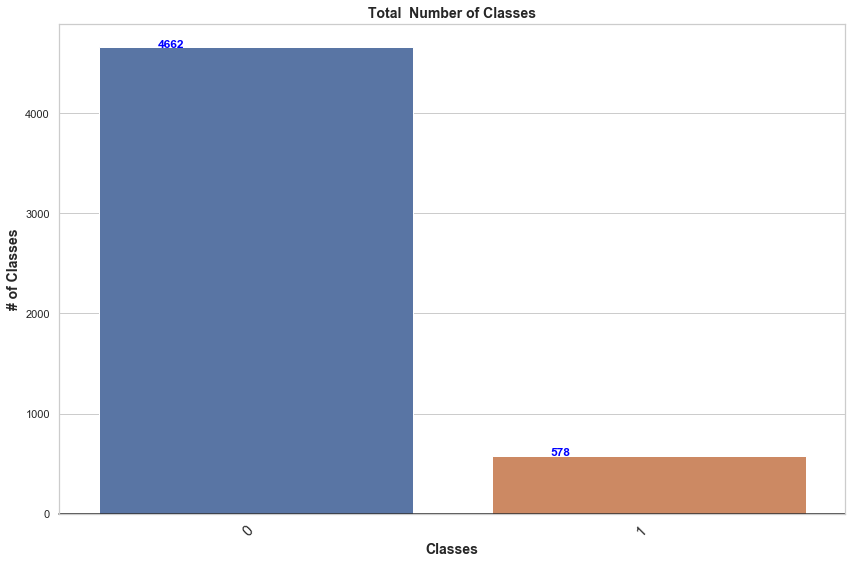

In [194]:
%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})
draw_col_shape(df_prediction,var_to_predict)

Random over-sampling:
1    4662
0    4662
Name: aaa_credit_card, dtype: int64


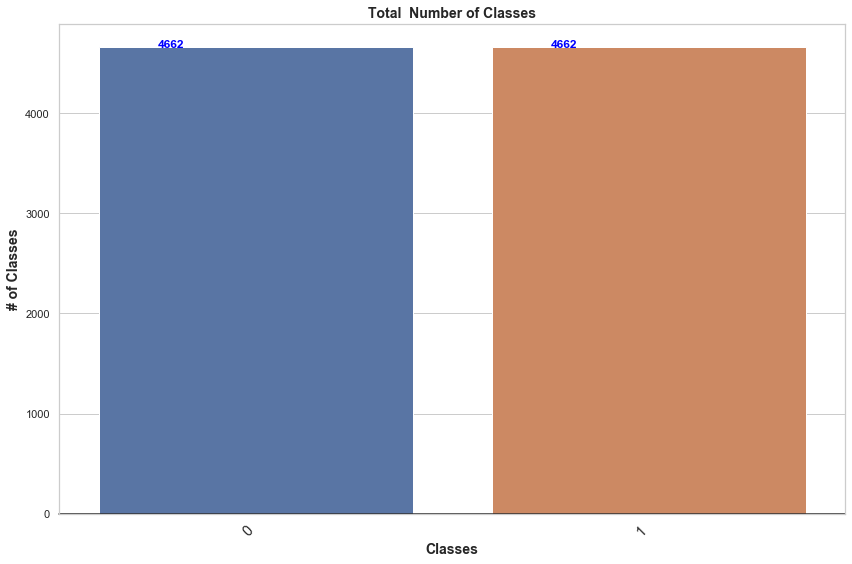

In [195]:
# Balance class Up Sampling
# As there is only 11 members that are using the mortgage service.
# Will upsample the 11 (yes) to 4952
# Evaluate imbalanced classification model with different metrics

# Class count
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]


df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over[var_to_predict[0]].value_counts())

draw_col_shape(df_test_over,var_to_predict)
plt.show()

Random down-sampling:
1    578
0    578
Name: aaa_credit_card, dtype: int64


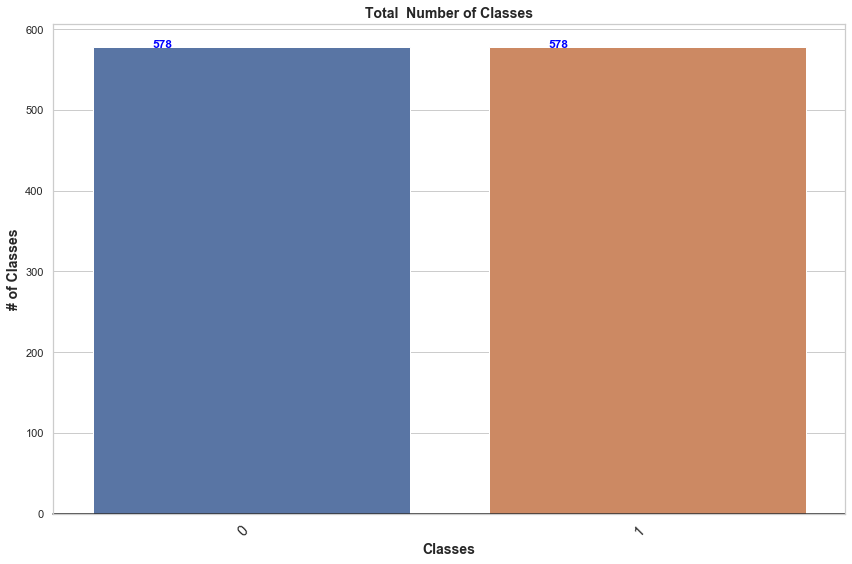

In [196]:
# Downsample Majority Class To Match Minority Class
# Indicies of each class' observations
count_class_0, count_class_1 = df_prediction[var_to_predict[0]].value_counts()

# Divide by class
df_class_0 = df_prediction[df_prediction[var_to_predict[0]] == 0]
df_class_1 = df_prediction[df_prediction[var_to_predict[0]] == 1]

df_class_0_down = df_class_0.sample(count_class_1, replace=True)
df_test_down = pd.concat([df_class_1, df_class_0_down], axis=0)

print('Random down-sampling:')
print(df_test_down[var_to_predict[0]].value_counts())

draw_col_shape(df_test_down,var_to_predict)
plt.show()

In [163]:
df_test_over.corr()

,total_calls,"income_10-19,999",income_100k+,"income_40 - 99,999","income_UNDER 39,999",tenure_+40 YEARS,tenure_BETWEEN 21 & 40 YEARS,tenure_UNDER 20 YEARS,credit_ranges_800+,credit_ranges_BELOW 700,credit_ranges_BETWEEN 700 & 799,education_COMPLETED COLLEGE,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),aaa_financial_service_0,aaa_financial_service_1,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_credit_card
total_calls,1.0000,-0.0062,-0.0159,0.0257,0.0291,-0.0385,0.0161,0.0341,0.0271,0.0305,-0.0246,-0.0191,-0.0021,-0.0016,0.0987,0.0045,0.0236,0.0315,-0.0723,-0.1084,0.1084,-0.0821,0.0821,0.0493
"income_10-19,999",-0.0062,1.0000,-0.1194,-0.1596,-0.0614,0.0282,-0.0374,-0.0005,-0.0310,0.1780,0.0063,-0.0447,0.0601,0.0133,-0.0460,-0.0062,-0.0080,-0.0089,0.0575,0.0164,-0.0164,-0.0293,0.0293,0.0243
income_100k+,-0.0159,-0.1194,1.0000,-0.3850,-0.1481,0.0046,0.0188,-0.0239,0.2403,-0.0962,0.2865,0.1911,0.0665,0.1560,0.1470,0.0158,-0.0121,-0.0143,-0.1001,-0.1086,0.1086,0.0084,-0.0084,0.0589
"income_40 - 99,999",0.0257,-0.1596,-0.3850,1.0000,-0.1980,0.0390,0.0013,-0.0513,0.0219,0.2297,0.2676,0.1002,0.1940,0.1691,-0.0065,-0.0443,0.0374,-0.0398,0.0696,0.0169,-0.0169,-0.0809,0.0809,0.1150
"income_UNDER 39,999",0.0291,-0.0614,-0.1481,-0.1980,1.0000,-0.0006,-0.0116,0.0119,-0.0150,0.1717,0.0339,-0.0146,0.0767,0.0463,-0.0190,0.0382,-0.0099,-0.0064,0.0288,0.0080,-0.0080,-0.0515,0.0515,0.0059
tenure_+40 YEARS,-0.0385,0.0282,0.0046,0.0390,-0.0006,1.0000,-0.6361,-0.6763,0.0389,-0.0079,0.0381,0.0361,-0.0050,0.0533,-0.1300,-0.1703,-0.0634,-0.1155,0.2112,-0.0362,0.0362,0.0058,-0.0058,0.1215
tenure_BETWEEN 21 & 40 YEARS,0.0161,-0.0374,0.0188,0.0013,-0.0116,-0.6361,1.0000,-0.1381,-0.0144,-0.0145,0.0205,0.0053,0.0050,-0.0079,0.1155,0.0953,-0.0129,-0.0215,-0.1237,0.0143,-0.0143,-0.0126,0.0126,-0.0598
tenure_UNDER 20 YEARS,0.0341,-0.0005,-0.0239,-0.0513,0.0119,-0.6763,-0.1381,1.0000,-0.0361,0.0240,-0.0685,-0.0514,0.0017,-0.0609,0.0566,0.1277,0.0937,0.1687,-0.1529,0.0328,-0.0328,0.0046,-0.0046,-0.0989
credit_ranges_800+,0.0271,-0.0310,0.2403,0.0219,-0.0150,0.0389,-0.0144,-0.0361,1.0000,-0.1489,-0.2527,0.0730,0.0236,0.1149,-0.0083,-0.0142,-0.0113,-0.0201,0.0298,-0.0198,0.0198,0.0002,-0.0002,-0.0004
credit_ranges_BELOW 700,0.0305,0.1780,-0.0962,0.2297,0.1717,-0.0079,-0.0145,0.0240,-0.1489,1.0000,-0.3814,0.0090,0.1773,0.0609,0.0084,0.0285,0.0448,-0.0152,0.0114,0.0124,-0.0124,-0.0669,0.0669,0.0834


In [148]:
df_test_down.describe()

,total_calls,total_cost,total_member_cost,"income_10-19,999",income_100k+,"income_40 - 99,999","income_UNDER 39,999",tenure_+40 YEARS,tenure_BETWEEN 21 & 40 YEARS,tenure_UNDER 20 YEARS,credit_ranges_800+,credit_ranges_BELOW 700,credit_ranges_BETWEEN 700 & 799,education_COMPLETED COLLEGE,education_HIGH SCHOOL,education_SOME COLLEGE,generation_BABY BOOMERS (1948 - 1968),generation_GENERATION X (1969 - 1980),generation_GENERATION Z (1994 - 2010),generation_MILLENIALS (1981 - 1993),generation_POST-WAR (< 1948),aaa_financial_service_0,aaa_financial_service_1,kcl_b_ind_mosaicsgrouping_BOOMERS,kcl_b_ind_mosaicsgrouping_GOLDEN YEAR,kcl_b_ind_mosaicsgrouping_MIDDLE CLASS MELTING POT,kcl_b_ind_mosaicsgrouping_POWER ELITE,kcl_b_ind_mosaicsgrouping_SINGLES AND STARTERS,occupation_group_MANAGEMENT,occupation_group_OTHER,occupation_group_PROFESSIONAL,occupation_group_RETIRED,aaa_auto_insurance_0,aaa_auto_insurance_1,aaa_credit_card
count,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000,1156.0000
mean,8.3348,136.9949,430.8381,0.0510,0.2336,0.3356,0.0727,0.7448,0.1263,0.1289,0.1003,0.1773,0.4048,0.1081,0.2033,0.2076,0.2578,0.0104,0.0009,0.0061,0.6869,0.9048,0.0952,0.2405,0.2820,0.0649,0.0761,0.0692,0.0943,0.0268,0.1497,0.2171,0.6817,0.3183,0.5000
std,20.2499,201.0262,1086.4959,0.2202,0.4233,0.4724,0.2597,0.4362,0.3323,0.3352,0.3006,0.3821,0.4911,0.3107,0.4026,0.4058,0.4376,0.1014,0.0294,0.0776,0.4640,0.2936,0.2936,0.4276,0.4502,0.2464,0.2653,0.2539,0.2924,0.1616,0.3569,0.4125,0.4660,0.4660,0.5002
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,2.0000,63.5700,63.2850,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.5000
75%,7.0000,174.1000,345.1875,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000
max,257.0000,2189.6000,11534.1500,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [106]:
df_test_over.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9324 entries, 1 to 2711
Data columns (total 113 columns):
length_of_residence                                                    9324 non-null float64
total_member_cost                                                      9324 non-null float64
income_10-19,999                                                       9324 non-null uint8
income_100-149,999                                                     9324 non-null uint8
income_150 - 174,999                                                   9324 non-null uint8
income_175 - 199,999                                                   9324 non-null uint8
income_20-29,999                                                       9324 non-null uint8
income_200 - 249,999                                                   9324 non-null uint8
income_250K+                                                           9324 non-null uint8
income_30-39,999                                                     

# Feature Selection

In [ ]:
# Identify predominant features to predict Credit Card users

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols, index=df_test_over.index)
y_df = pd.DataFrame(df_test_over,columns=y_cols, index=df_test_over.index)

scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols, index=X_df)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

# Initialize the model
logreg = LogisticRegression(penalty='l2',solver="liblinear")

# Perform feature selection
rfe = RFE(logreg)
rfe = rfe.fit(trainX, trainy)

# Get columns names of the selected features
new_feat = []
ix = 0
for i in rfe.support_:
    if i: 
        new_feat.append(X_cols[ix])
    ix += 1
print('Total Selected Features : %.0f' % len(new_feat), ' out of %.0f' % len(rfe.support_))


In [ ]:
print('New Selected Features :\n', new_feat)


# Implement and verify features selected

In [139]:
import statsmodels.api as sm

np.random.seed(42)

# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols,index=df_test_over.index)
y_df = pd.DataFrame(df_test_over,columns=y_cols, index=df_test_over.index)

scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols, index=X_df.index)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

rfe_trainX = pd.DataFrame(trainX,columns=X_cols, index=trainX.index)
logit_model=sm.Logit(trainy,rfe_trainX)
result=logit_model.fit(method='newton', maxiter=35)
print(result.summary())

         Current function value: 0.640002
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        aaa_credit_card   No. Observations:                 4662
Model:                          Logit   Df Residuals:                     4630
Method:                           MLE   Df Model:                           31
Date:                Fri, 14 Feb 2020   Pseudo R-squ.:                 0.07654
Time:                        09:33:29   Log-Likelihood:                -2983.7
converged:                      False   LL-Null:                       -3231.0
Covariance Type:            nonrobust   LLR p-value:                 6.378e-85
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
total_calls                                            3.6959   

# Observations
* The p-values for most of the variables are very small, therefore, most of them are significant to the model.
The following feature are not significant and will be dropped.
* a) total_calls
* b) total_member_cost
* c) cancel_reason_NOT CANCELLED
* d) plus_indicator_description_PLUS MEMBERSHIP WITH MOTORCYCLE COVERAGE

In [ ]:
#feat_to_drop = ['total_calls', 'total_member_cost', 'cancel_reason_NOT CANCELLED', 'plus_indicator_description_PLUS MEMBERSHIP WITH MOTORCYCLE COVERAGE']
#scaled_df_mm.drop(labels=feat_to_drop,axis=1, inplace=True)

In [ ]:
# Split Train and test
#trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)
#rfe_trainX = pd.DataFrame(trainX,columns=trainX.columns, index=trainX.index)
#logit_model=sm.Logit(trainy,rfe_trainX)
#result=logit_model.fit(method='lbfgs', maxiter=35)
#print(result.summary())

# Grid Search Logistic Regression

In [197]:
# Grid Search with Up Sampling
# Logistic regression
np.random.seed(42)

X_df = pd.DataFrame(df_test_over,columns=X_cols,index=df_test_over.index)
y_df = pd.DataFrame(df_test_over,columns=y_cols, index=df_test_over.index)

scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols, index=X_df.index)

trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

logregpipe = Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                   ('logreg',LogisticRegression(penalty='l2',multi_class="auto",solver="liblinear"))])

# Grid search to determine the value of C
param_grid = {'logreg__C':np.arange(0.01,100,10)}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=5,return_train_score=True, scoring='accuracy')
logreg_cv.fit(trainX, trainy)
print('Best C Parameter : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))

Best C Parameter :  {'logreg__C': 0.01}
Accuracy Training Data : 0.628


In [198]:
# Grid Search using down sampling
# Logistic regression
np.random.seed(42)

X_df = pd.DataFrame(df_test_down,columns=X_cols,index=df_test_down.index)
y_df = pd.DataFrame(df_test_down,columns=y_cols, index=df_test_down.index)

scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols, index=X_df.index)

trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

logregpipe = Pipeline([('scale', MinMaxScaler(feature_range=(0, 1))),
                   ('logreg',LogisticRegression(penalty='l2',multi_class="auto",solver="liblinear"))])

# Grid search to determine the value of C
param_grid = {'logreg__C':np.arange(0.01,100,10)}
logreg_cv = GridSearchCV(logregpipe,param_grid,cv=5,return_train_score=True, scoring='accuracy')
logreg_cv.fit(trainX, trainy)
print('Best C Parameter : ', logreg_cv.best_params_)

bestlogreg = logreg_cv.best_estimator_
bestlogreg.fit(trainX,trainy)
bestlogreg.coef_ = bestlogreg.named_steps['logreg'].coef_
print('Accuracy Training Data : %.3f' % bestlogreg.score(trainX,trainy))

Best C Parameter :  {'logreg__C': 10.01}
Accuracy Training Data : 0.635


Accuracy training          : 0.638
Accuracy test              : 0.632
Precision                  : 0.614
Recall                     : 0.679
F-measure                  : 0.645
Log-Loss                   : 12.721
No Skill - ROC AUC         : 0.500
Logistic - ROC AUC         : 0.670
Cross Validation Accuracy  : 0.623 (+/- 0.026)


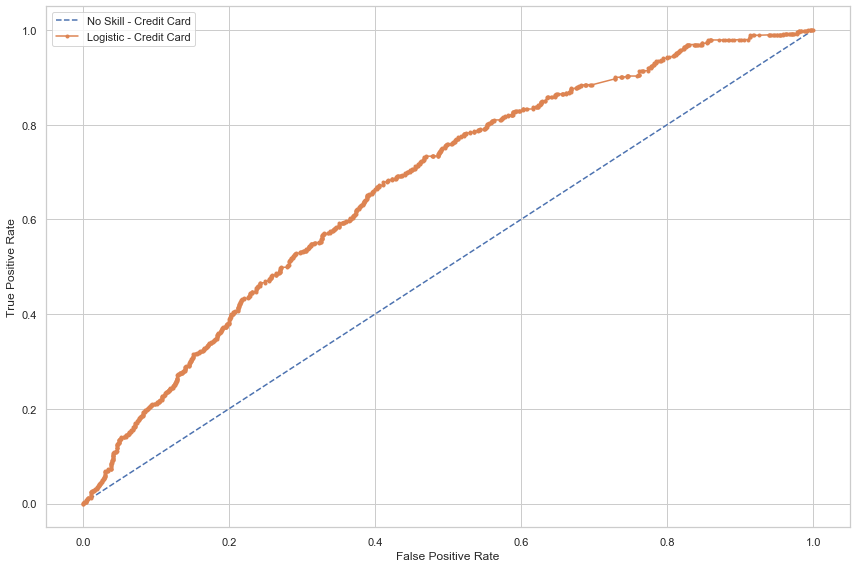

In [243]:
# Use Logistic Regression algorithms to classify which customers are going to use credit card services or not (0 = No, 1 = Yes)
# Using Oversample Dataframe with transformation MinMax Scaler

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

# Define model 
model = LogisticRegression(penalty='l2',multi_class="auto", solver="liblinear", C=90)

# Fit model
model.fit(trainX, trainy)

# Predict on test set
yhat = model.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = model.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
scores = cross_val_score(model, testX, testy, cv=5)

# Evaluate predictions
print('Accuracy training          : %.3f' % accuracy_score(model.predict(trainX), trainy))
print('Accuracy test              : %.3f' % accuracy_score(testy, yhat))
print('Precision                  : %.3f' % precision_score(testy, yhat))
print('Recall                     : %.3f' % recall_score(testy, yhat))
print('F-measure                  : %.3f' % f1_score(testy, yhat))
print('Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic - ROC AUC         : %.3f' % (lr_auc))
print("Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - Credit Card')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - Credit Card')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Confusion matrix - Credit Card, without normalization
[[1384  980]
 [ 737 1561]]
Normalized confusion matrix - Credit Card
[[0.59 0.41]
 [0.32 0.68]]


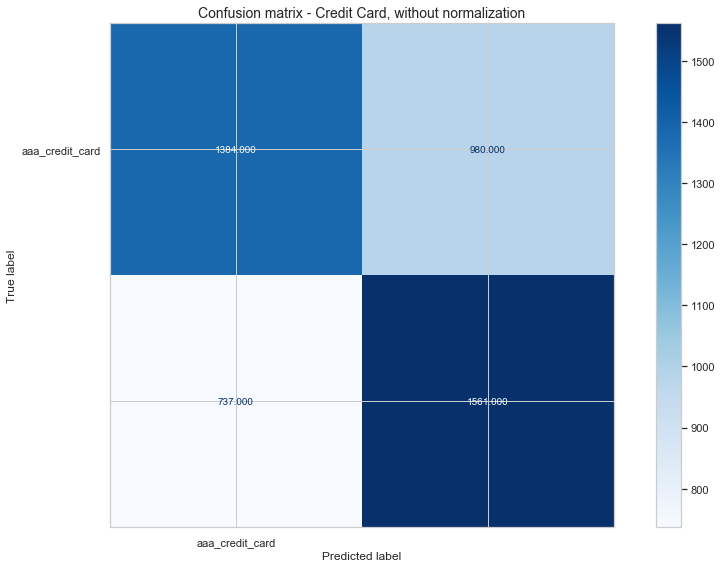

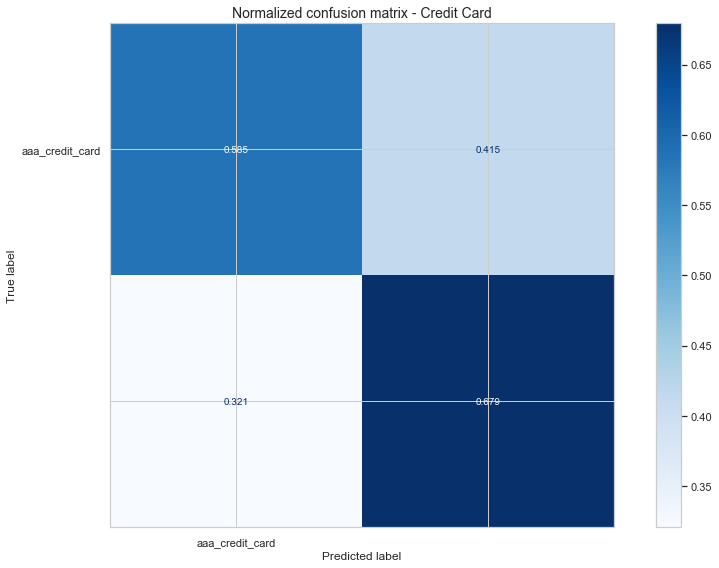

In [244]:
# Confusion Metrics
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - Credit Card, without normalization", None),
                  ("Normalized confusion matrix - Credit Card", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [245]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': model.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts, height_constant=30, index=False)
py.iplot(fig)

# k-Nearest Neighbors

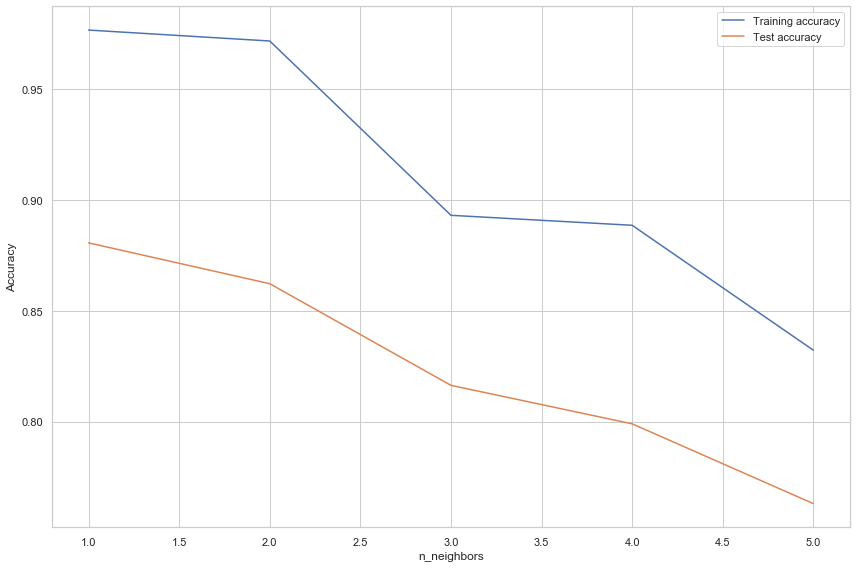

In [240]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)


training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 6)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(trainX, trainy)
    # record training set accuracy
    training_accuracy.append(knn.score(trainX, trainy))
    # record test set accuracy
    test_accuracy.append(knn.score(testX, testy))

plt.plot(neighbors_settings, training_accuracy, label="Training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('credit_card_knn_compare_model')

# Observations
The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the training accuracy drops, indicating that using the single nearest neighbor leads to a model that is too complex.

The best performance is somewhere around one neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is more than 82% accuracy, which might still be pretty good.

The above plot suggests that we should shoose n_neighbors=1. 

Accuracy of K-NN classifier on training set: 0.98
Accuracy of K-NN classifier on test set: 0.88
Precision                  : 0.827
Recall                     : 0.958
F-measure                  : 0.888
Log-Loss                   : 4.119
No Skill - ROC AUC         : 0.500
Logistic - ROC AUC         : 0.882
Cross Validation Accuracy  : 0.856 (+/- 0.025)


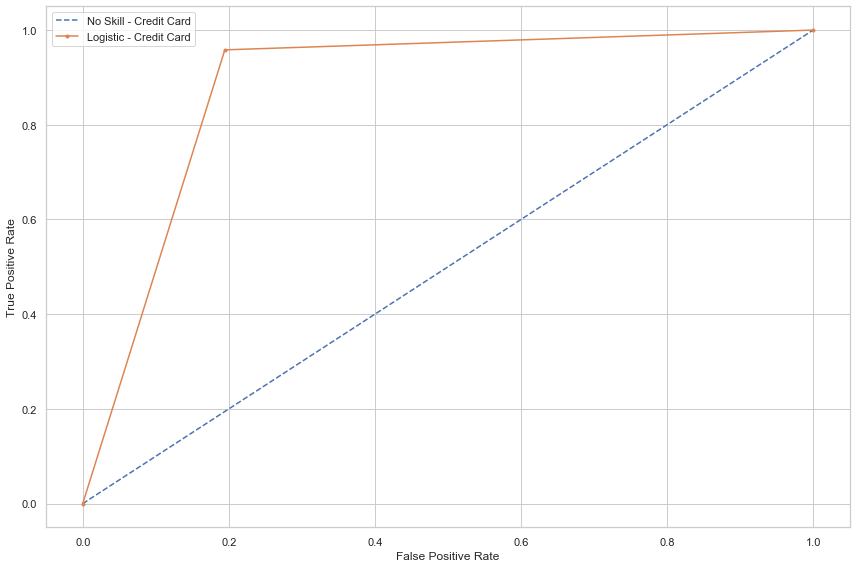

In [241]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(trainX, trainy)

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(trainX, trainy)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(testX, testy)))

# Predict on test set
yhat = knn.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = knn.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
scores = cross_val_score(knn, testX, testy, cv=5)

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Precision                  : %.3f' % precision_score(testy, yhat))
print('Recall                     : %.3f' % recall_score(testy, yhat))
print('F-measure                  : %.3f' % f1_score(testy, yhat))
print('Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic - ROC AUC         : %.3f' % (lr_auc))
print("Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - Credit Card')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - Credit Card')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Confusion matrix - Credit Card, without normalization
[[1904  460]
 [  96 2202]]
Normalized confusion matrix - Credit Card
[[0.81 0.19]
 [0.04 0.96]]


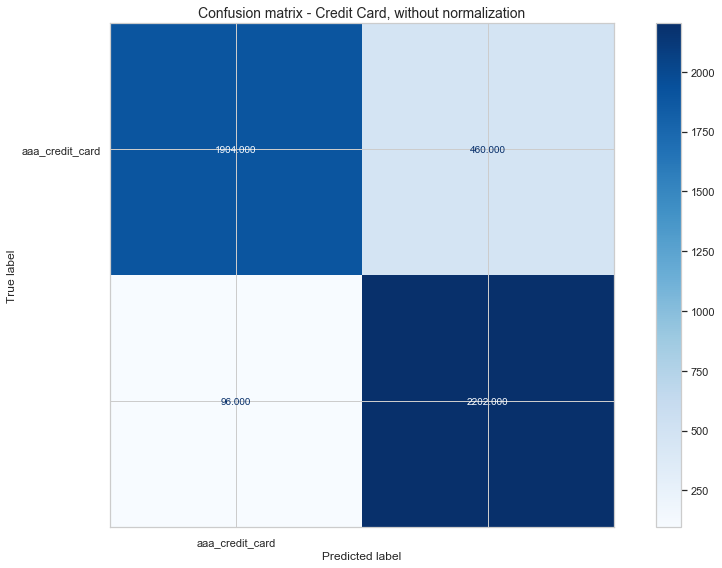

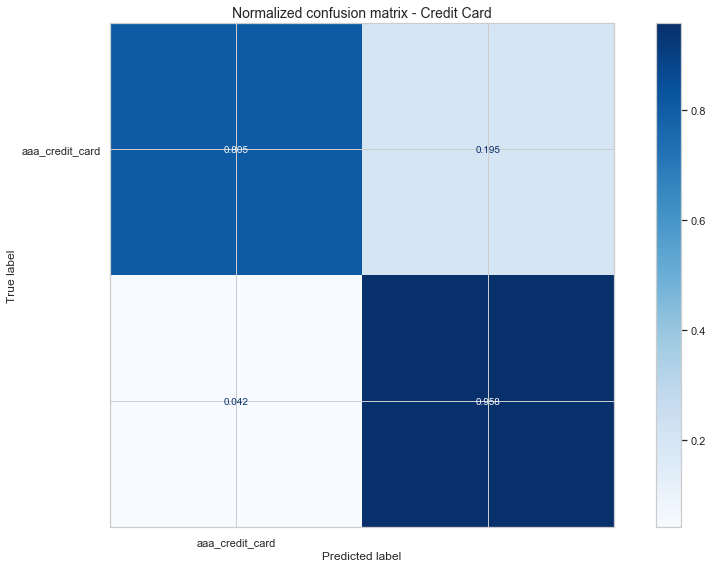

In [229]:
# Confusion Metrics
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - Credit Card, without normalization", None),
                  ("Normalized confusion matrix - Credit Card", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# CART  Model - DecisionTreeClassifier

In [264]:
# DecisionTreeClasifier
np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

#create a dictionary of all values we want to test
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 80)}

# decision tree model
cart = DecisionTreeClassifier()

#use gridsearch to test all values
cart_gscv = GridSearchCV(cart, param_grid, cv=num_folds)

#fit model to data
cart_gscv.fit(trainX, trainy)
print('Best parameters : ', cart_gscv.best_params_)


Best parameters :  {'criterion': 'entropy', 'max_depth': 45}


# Observation
Based on the grid search above, th best parameter for the Decession Tree Classifier is:
* criterion = entropy
* MaxDepth is 45

Accuracy on training set: 0.981
Accuracy on test set: 0.883
Precision                  : 0.829
Recall                     : 0.961
F-measure                  : 0.890
Log-Loss                   : 4.045
No Skill - ROC AUC         : 0.500
Logistic - ROC AUC         : 0.899
Cross Validation Accuracy  : 0.859 (+/- 0.016)


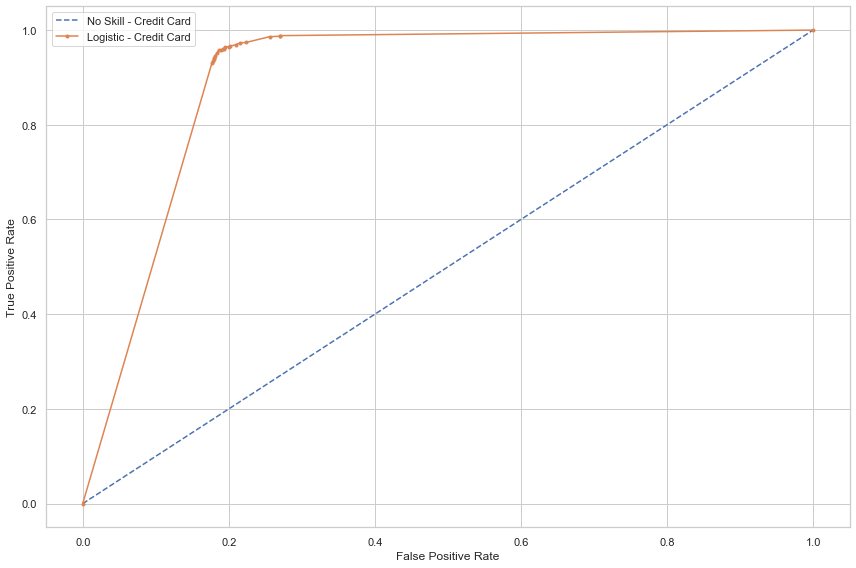

In [267]:
# Modeling based on the outcome of the grid serach
cart = DecisionTreeClassifier(criterion = 'entropy', max_depth=45)
cart.fit(trainX, trainy)

# Predict on test set
yhat = cart.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = cart.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
scores = cross_val_score(cart, testX, testy, cv=5)

print("Accuracy on training set: {:.3f}".format(cart.score(trainX, trainy)))
print("Accuracy on test set: {:.3f}".format(cart.score(testX, testy)))

# Evaluate predictions
#print('Accuracy                   : %.3f' % accuracy_score(testy, yhat))
print('Precision                  : %.3f' % precision_score(testy, yhat))
print('Recall                     : %.3f' % recall_score(testy, yhat))
print('F-measure                  : %.3f' % f1_score(testy, yhat))
print('Log-Loss                   : %.3f' % log_loss(testy, yhat))
print('No Skill - ROC AUC         : %.3f' % (ns_auc))
print('Logistic - ROC AUC         : %.3f' % (lr_auc))
print("Cross Validation Accuracy  : %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill - Credit Card')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - Credit Card')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Confusion matrix - Credit Card, without normalization
[[1908  456]
 [  90 2208]]
Normalized confusion matrix - Credit Card
[[0.81 0.19]
 [0.04 0.96]]


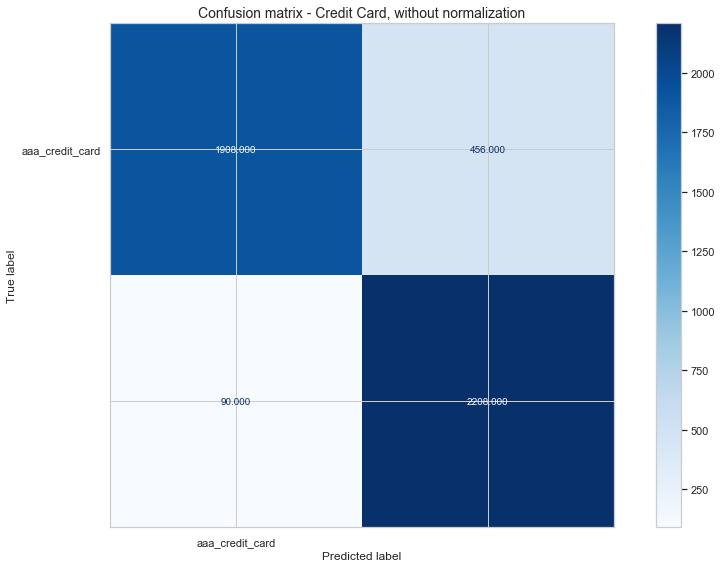

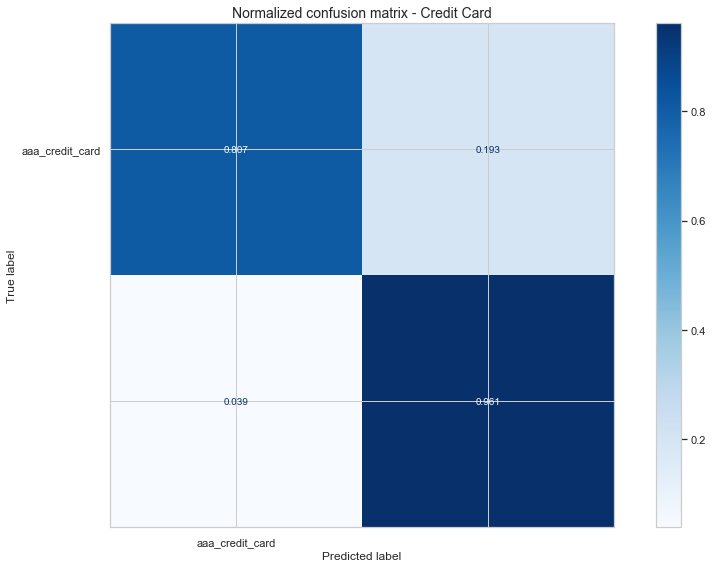

In [269]:
# Confusion Metrics
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix - Credit Card, without normalization", None),
                  ("Normalized confusion matrix - Credit Card", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cart, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Feature importance in trees
feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target.” The feature importances always sum to 1:

In [270]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': cart.feature_importances_})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts.rename(columns={"feature": "Features (MinMax Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts, height_constant=30, index=False)
py.iplot(fig)

# XGBOOST Model

# SVM Model

In [253]:
# SVM grid search evaluationq1|

np.random.seed(42)
# Create input and output dataframes
X_df = pd.DataFrame(df_test_over,columns=X_cols)
y_df = pd.DataFrame(df_test_over,columns=y_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df_mm = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=X_cols)

num_folds = 10
scoring = 'accuracy'

# Split Train and test
trainX, testX, trainy, testy = train_test_split(scaled_df_mm, y_df, test_size=0.50)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
svc = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(trainX, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.645431 using {'C': 2.0, 'kernel': 'rbf'}
0.631489 (0.020125) with: {'C': 0.1, 'kernel': 'linear'}
0.507079 (0.028309) with: {'C': 0.1, 'kernel': 'poly'}
0.627413 (0.015702) with: {'C': 0.1, 'kernel': 'rbf'}
0.625697 (0.015714) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.632776 (0.020571) with: {'C': 0.3, 'kernel': 'linear'}
0.507079 (0.028309) with: {'C': 0.3, 'kernel': 'poly'}
0.625912 (0.017735) with: {'C': 0.3, 'kernel': 'rbf'}
0.625054 (0.020820) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.632776 (0.020370) with: {'C': 0.5, 'kernel': 'linear'}
0.511583 (0.033814) with: {'C': 0.5, 'kernel': 'poly'}
0.634492 (0.018701) with: {'C': 0.5, 'kernel': 'rbf'}
0.622909 (0.019794) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.632132 (0.021398) with: {'C': 0.7, 'kernel': 'linear'}
0.585800 (0.047820) with: {'C': 0.7, 'kernel': 'poly'}
0.635779 (0.017946) with: {'C': 0.7, 'kernel': 'rbf'}
0.623552 (0.018929) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.630631 (0.022416) with: {'C': 0.9, 'kernel': 'linear'

# Algorithms Search and Testing

LR: 0.627846 (0.016644)
LDA: 0.625914 (0.016218)
KNN: 0.733807 (0.017314)
CART: 0.867858 (0.014846)
NB: 0.544831 (0.029182)
SVM: 0.638570 (0.018990)
AB: 0.636851 (0.015445)
GBM: 0.707625 (0.021871)
RF: 0.913329 (0.021453)
ET: 0.928994 (0.013373)


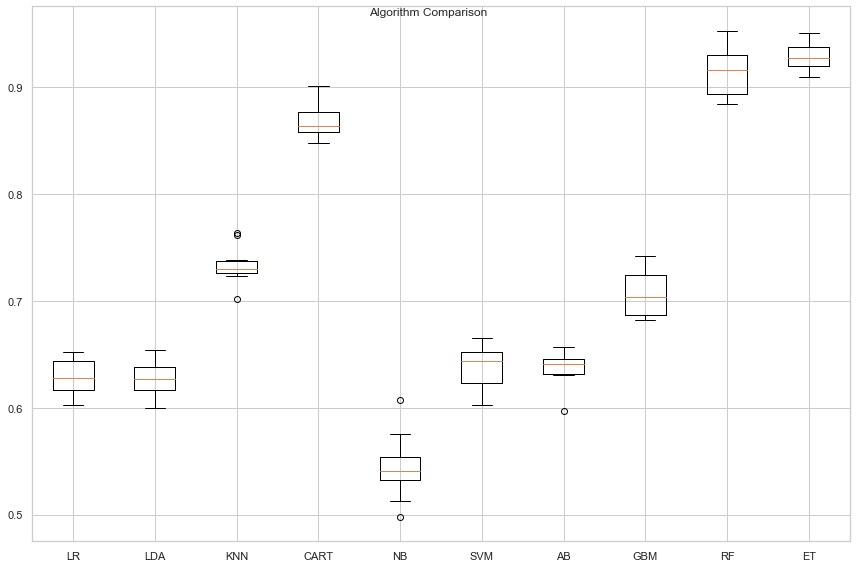

In [278]:
# Algorithms Search
num_folds = 10
np.random.seed(42)
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Ensembles Methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, trainX, trainy, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Binary Classifier

In [ ]:
# Binary Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='log')
sgd_clf.fit(trainX, trainy)
sgd_scores = cross_val_score(sgd_clf, trainX, trainy, cv=10)
sgd_scores.mean()

In [ ]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': model.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts.rename(columns={"feature": "Features (no Scaling)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts, height_constant=30, index=False)
py.iplot(fig)

In [ ]:
sns.set(style="whitegrid")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Coefs",fontsize=8, fontweight='bold')
plt.xlabel("Features", fontsize=8, fontweight='bold')
plt.title('Features of Logistics Regression',loc='center', fontdict={'fontsize':14, 'fontweight':'bold'})
sns.barplot(x=coef_df_lgr.feature, y=coef_df_lgr.coefs)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small')
plt.show()

In [ ]:
# Scale fields using Standard Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Standard Scaler
scaler = StandardScaler()
scaled_df_std = scaler.fit_transform(df)
scaled_df_std = pd.DataFrame(scaled_df_std, columns=features_to_scale)


for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    
    ax1.set_title('Before Scaling Standard Scaler')
    ax2.set_title('After Standard Scaler')

    sns.kdeplot(df[col], ax=ax1)
    sns.kdeplot(scaled_df_std[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_std.describe()

In [ ]:
# Scale fields using Min-Max scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Min-Max Scaler
scaler = MinMaxScaler()
scaled_df_mm = scaler.fit_transform(df)
scaled_df_mm = pd.DataFrame(scaled_df_mm, columns=features_to_scale)

for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Min-Max')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Min-Max Scaling')
    sns.kdeplot(scaled_df_mm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_mm.describe()

In [ ]:
# Scale fields using Robust Scaler

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Robust Scaler- excellent with outliers
scaler = RobustScaler()
scaled_df_rs = scaler.fit_transform(df)
scaled_df_rs = pd.DataFrame(scaled_df_rs, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Robust Scaling')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Robust Scaling')
    sns.kdeplot(scaled_df_rs[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_rs.describe()

In [ ]:
# Scale fields using Normalizer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# Normalizer
scaler = Normalizer()
scaled_df_nm = scaler.fit_transform(df)
scaled_df_nm = pd.DataFrame(scaled_df_nm, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling Normalizer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After Normalizer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_nm.describe()

In [ ]:
# Scale fields using Quantile Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# QuantileTransformer
scaler = QuantileTransformer(n_quantiles=200, output_distribution='normal')
scaled_df_qt = scaler.fit_transform(df)
scaled_df_qt = pd.DataFrame(scaled_df_qt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling QuantileTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After QuantileTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_qt.describe()

In [ ]:
# Scale fields using Power Transformer

features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
df = pd.DataFrame(df_test_over, columns=features_to_scale)

# PowerTransformer
scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
scaled_df_pt = scaler.fit_transform(df)
scaled_df_pt = pd.DataFrame(scaled_df_pt, columns=features_to_scale)
for col in features_to_scale:
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    ax1.set_title('Before Scaling PowerTransformer')
    sns.kdeplot(df[col], ax=ax1)
    ax2.set_title('After PowerTransformer')
    sns.kdeplot(scaled_df_nm[col], ax=ax2)
    plt.show()

In [ ]:
scaled_df_pt.describe()

In [ ]:
# As there is only 11 memebrs that are using the mortgage service..
# Will upsample the 11 (yes) to 5229
# Evaluate imbalanced classification model with different metrics
np.random.seed(42)
features_to_scale = ['aaa_mean_age', 'length_of_residence', 'aaa_mean_child', 
                     'total_calls', 'total_member_cost', 'total_cost'
                    ]
                     
df_new = df_test_over.copy()

# Going to use the Normalizer Scaler as it is giving a range between 0-1
df_new[features_to_scale] = scaled_df_nm[features_to_scale]

X_df = pd.DataFrame(df_new,columns=X_cols)
y_df = pd.DataFrame(df_new,columns=y_cols)

# Split Train and test
trainX, testX, trainy, testy = train_test_split(X_df, y_df, test_size=0.50)

# Define model 
model = LogisticRegression(solver='liblinear')

# Fit model
model.fit(trainX, trainy)

# Predict on test set
yhat = model.predict(testX)

# Generate a no skill prediction for ROC Curve
ns_probs = [0 for _ in range(len(testy))]

# Predict probabilities
lr_probs = model.predict_proba(testX)

# Keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# Calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# Calculate Cross valdation scores
scores = cross_val_score(model, testX, testy, cv=10)

# Evaluate predictions
print('Accuracy (Normalizer Transformer)                  : %.3f' % accuracy_score(testy, yhat))
print('Precision (Normalizer Transformer)                 : %.3f' % precision_score(testy, yhat))
print('Recall (Normalizer Transformer)                    : %.3f' % recall_score(testy, yhat))
print('F-measure (Normalizer Transformer)                 : %.3f' % f1_score(testy, yhat))
print('Log-Loss (Normalizer Transformer)                  : %.3f' % log_loss(testy, yhat))
print('No Skill - ROC AUC (Normalizer Transformer)        : %.3f' % (ns_auc))
print('Logistic - ROC AUC (Normalizer Transformer)        : %.3f' % (lr_auc))
print("Cross Validation Accuracy (Normalizer Transformer) : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic - Normalizer Transformer')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Confusion Metrics
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, testX, testy,
                                 display_labels=testy,
                                 values_format='.3f',
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
coef_df_lgr = pd.DataFrame({'feature':testX.columns, 'coefs': model.coef_[0]})
coef_df_lgr["abs_coeff"] = coef_df_lgr['coefs'].abs()
coef_df_lgr.sort_values("abs_coeff",ascending=False,inplace=True)
coef_df_lgr.nlargest(30,columns=["abs_coeff"])
counts = pd.DataFrame(coef_df_lgr.nlargest(30,columns=["abs_coeff"]), index=None)
#counts.reset_index(inplace=True)
counts.rename(columns={"feature": "Features (Normalizer Transformer)", 'coefs':'Coefficients', 'abs_coeff': "ABS of Coeffs."}, inplace=True)
fig = ff.create_table(counts, height_constant=30, index=False)
py.iplot(fig)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_test_over['aaa_mortgage'].values)
plt.xlabel('Row number')
plt.ylabel('y value')
plt.title('Change in y value over the data set')
plt.show();